
# STARGA: Unsupervised Spatial–Temporal Augmentation in Rare-event Detection with Generative Models


# 📌 Introduction
This notebook implements a STARGA framework for video anomaly detection. 
The architecture consists of two generators and two discriminators: 
## Generators:
- **SpatialGenerator:** Obtained via segmentation (using GrabCut) and edge detection, this highlights object boundaries and structure. This parallels the role of the SpatialContextGenerator, which is tasked with producing realistic edge maps.
- **TemporalGenerator:** Derived from frame differencing and smoothing, this captures the dynamics of moving objects. It is similar to how the TemporalPatternGenerator in STARGA learns the evolution of frame differences across a sequence.
## Discriminators:
Each generator has a corresponding discriminator to evaluate the realism of its outputs:

- **SpatialDiscriminator:** assesses the realism of the edge-like images produced by the SpatialContextGenerator.
- **TemporalDiscriminator:** evaluates the generated temporal dynamics, ensuring they align with genuine motion patterns observed in video sequences.
- 
By leveraging these dual pathways—one for spatial context and one for temporal patterns—the STARGA framework can effectively detect anomalies in videos by comparing the generated representations with the actual preprocessed data derived from techniques like frame differencing, smoothing, segmentation, and edge detection.


The following cells write each module to disk and then run the training (or evaluation) procedure.

# ⚙️ Configuration Module Overview
This module sets up essential configurations for training and testing, including directory creation, shared settings, and utility functions for converting configuration dictionaries into class attributes.

## Directory Setup:
Checks for and creates the weights and results/ped2 directories if they do not exist.

## Shared Configuration:
Uses a dictionary (share_config) to store common settings such as mode, dataset, and img_size.

## Dictionary-to-Class Conversion:
The dict2class class converts the configuration dictionary into an object with attribute-style access, making it easy to print and access configuration values.

## Configuration Update:
The update_config function modifies the shared configuration based on input arguments and mode (train or test), ensuring that paths and parameters are set appropriately depending on whether the code runs locally or on Kaggle.

## Boolean Conversion Utility:
The str2bool function converts string inputs into boolean values for command-line argument parsing.

In [1]:
%%writefile config.py
from glob import glob
import os


if not os.path.exists('weights'):
    os.mkdir('weights')
if not os.path.exists('results'):
    os.mkdir('results')
if not os.path.exists('results/ped2'):
    os.mkdir('results/ped2')


share_config = {'mode': 'training',
                'dataset': 'ped2',
                'img_size': (256, 256)
}

class dict2class:
    def __init__(self, config):
        for k, v in config.items():
            self.__setattr__(k, v)

    def print_cfg(self):
        print('\n' + '-' * 30 + f'{self.mode} cfg' + '-' * 30)
        for k, v in vars(self).items():
            print(f'{k}: {v}')
        print()


def update_config(args=None, mode=None):
    share_config['mode'] = mode
    share_config['dataset'] = args.dataset
    
    if args.is_local:
        share_config['root_folder'] = ''
    else:
        share_config['root_folder'] = '/kaggle/input/ped2-v1/' 
    root_folder=share_config['root_folder'] 

    if mode == 'train':
        share_config['batch_size'] = args.batch_size
        share_config['train_data'] =   share_config['root_folder']    + args.dataset + '/training/frames/'
        share_config['test_root_path'] =   share_config['root_folder']   + args.dataset + '/testing/'
        share_config['train_root_path'] =   share_config['root_folder']   + args.dataset + '/training/'
        share_config['test_data'] =  share_config['root_folder']  + args.dataset + '/testing/frames/'
        share_config['g_lr'] = 0.0002
        share_config['d_lr'] = 0.00002
        share_config['show_flow'] = args.show_flow
        share_config['resume'] = args.resume if args.resume else None
        share_config['save_interval'] = args.save_interval
        share_config['val_interval'] = args.val_interval
        share_config['manualseed'] = args.manualseed
        share_config['generator_iters'] = args.generator_iters
        share_config['cuda'] = args.cuda
        share_config['is_local'] = args.is_local

    elif mode == 'test':
        share_config['test_data'] = share_config['root_folder']    + args.dataset + '/testing/frames/'
        share_config['test_root_path'] =   share_config['root_folder']  + args.dataset + '/testing/'
        
        share_config['trained_model'] = args.trained_model
        share_config['show_curve'] = args.show_curve
        share_config['show_heatmap'] = args.show_heatmap
        share_config['generator_iters'] = args.generator_iters
        share_config['resume'] =args.resume
        share_config['cuda'] = args.cuda
        
        share_config['manualseed'] = args.manualseed
        share_config['batch_size'] = args.batch_size
        share_config['is_local'] = args.is_local
    return dict2class(share_config)  # change dict keys to class attributes



def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')
    

Writing config.py


# 📁 Dataset Module Overview
This module handles all aspects of video data loading, preprocessing, and organization for anomaly detection tasks. It provides helper functions for image processing and defines custom dataset classes for training and testing, ensuring data is efficiently prepared for use with PyTorch models.
## Helper Functions:

🖼️ np_load_frame: Loads an image from disk, applies transformations, resizes, normalizes pixel values to [-1, 1], and formats it to (C, H, W) for PyTorch.

⚡ attention_canny_edge_detection: Uses Canny edge detection, modulated by an attention map based on the difference between a frame and its background, to produce enhanced edge images.

🔄 apply_frame_differencing: Implements background subtraction by computing the absolute difference between a frame and a background, normalizing and formatting the result.

🔀 load_frame_all_types: Simultaneously loads the original image, frame difference image, and edge image, ensuring all are resized, normalized, and formatted correctly.

## Video Data Structure:

📦 VideoObject: A simple class to encapsulate all related information for a video, including the background frame, lists of frame paths, edge frame paths, frame difference paths, video ID, and total number of frames.

## Custom Dataset Classes:

🚀 train_dataset: Organizes training data by extracting video sequences with a specified length and overlap. It also handles background extraction (using average or median frames) and converts frames into PyTorch tensors for training.

🔍 test_dataset: Similar to train_dataset, but specifically tailored for testing data. It processes video sequences and loads them in a format suitable for inference.

📊 Label_loader: Loads ground truth labels from MATLAB files for the UCSD Ped2 dataset, mapping abnormal events to frame-level labels and preparing them in sequences that align with the video data.

In [2]:
%%writefile dataset.py
import random
import torch
import numpy as np
import cv2
import glob
import os
import scipy.io as scio
from torch.utils.data import Dataset
from torchvision.utils import save_image
from PIL import Image
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from numpy import array, uint8



def np_load_frame(filename, resize_h, resize_w, transform=None):
    img = cv2.imread(filename)
    if img is None:
        raise FileNotFoundError(f"Error: Unable to load image {filename}")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    if transform:
        img = Image.fromarray(img)  # Convert to PIL image
        img = transform(img)        # Apply transform
        img = np.array(img)         # Convert back to numpy array

    img_resized = cv2.resize(img, (resize_w, resize_h), interpolation=cv2.INTER_LINEAR).astype('float32')
    img_resized = (img_resized / 127.5) - 1.0  # Normalize to range [-1, 1]
    
    if img_resized.ndim == 2:  # Handle grayscale images
        img_resized = np.expand_dims(img_resized, axis=-1)

    img_resized = np.transpose(img_resized, (2, 0, 1))  # Convert to (C, H, W)
    
    return img_resized
def attention_canny_edge_detection(frame, background_frame):
    """
    Applies Canny edge detection and modulates it using an attention map.
    
    Parameters:
        frame (numpy.ndarray): Input Sequence of frames (e.g., video frame).
        median_frame (numpy.ndarray): Median frame used for attention modulation.
    
    Returns:
        numpy.ndarray: Edge-detected image of shape (240, 360, 1).
    """
    if frame.dtype != np.uint8:
        frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    if background_frame.dtype != np.uint8:
        background_frame = cv2.normalize(background_frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Step 1: Apply Canny Edge Detection
    canny_edges = cv2.Canny(image, 100, 200)

    # Step 2: Compute Attention Map
    attention = cv2.cvtColor(frame - background_frame, cv2.COLOR_BGR2GRAY)

    # Normalize attention map to uint8 if needed
    if attention.dtype != np.uint8:
        attention = cv2.normalize(attention, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


    # Step 4: Modulate Canny Edges with Attention Map
    enhanced_edges = cv2.bitwise_and(canny_edges, attention)
    # Step 5: Reshape to (h, w, 1)
    enhanced_edges = np.expand_dims(enhanced_edges, axis=-1)
    enhanced_edges = np.transpose(enhanced_edges, (2, 0, 1))
    return enhanced_edges  # Shape: (h, w, 1)
def apply_frame_differencing(frame,background):
    """Applies simple frame differencing for background subtraction."""
    # background = frames[0]  # Use the first frame as reference
    
    fg_mask = cv2.absdiff(frame, background.astype(np.float32))  # Difference between first and second frame
    fg_mask = cv2.cvtColor(fg_mask, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    
    fg_mask = (fg_mask / 127.5) - 1.0  # Normalize to range [-1, 1]
    
    fg_mask = np.transpose(fg_mask, ( 2, 0,1))
         
    return fg_mask

def load_frame_all_types(filename, resize_h, resize_w,edge_frame_path, diff_frame_path):
    # ✅ Load images
    img = cv2.imread(filename)
    diff_frame = cv2.imread(diff_frame_path)
    edge_frame = cv2.imread(edge_frame_path, cv2.IMREAD_GRAYSCALE)  # Ensure grayscale
    if img is None or diff_frame is None or edge_frame is None:
        raise FileNotFoundError(f"Error: Unable to load one of the images!")

    # ✅ Resize images
    img_resized = cv2.resize(img, (resize_w, resize_h), interpolation=cv2.INTER_LINEAR).astype(np.float32)
    diff_frame_resized = cv2.resize(diff_frame, (resize_w, resize_h), interpolation=cv2.INTER_LINEAR).astype(np.float32)
    edge_frame_resized = cv2.resize(edge_frame, (resize_w, resize_h), interpolation=cv2.INTER_LINEAR).astype(np.float32)

    # ✅ Convert RGB images from BGR → RGB
    img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    diff_frame_resized = cv2.cvtColor(diff_frame_resized, cv2.COLOR_BGR2RGB)
    
    # ✅ Normalize images to range [-1, 1]
    img_resized = (img_resized / 127.5) - 1.0
    diff_frame_resized = (diff_frame_resized / 127.5) - 1.0
    edge_frame_resized = (edge_frame_resized / 127.5) - 1.0  # Grayscale normalization
   
    # ✅ Ensure grayscale has the correct dimensions (1, H, W) instead of (H, W)
    edge_frame_resized = np.expand_dims(edge_frame_resized, axis=0)  # Ensure (1, H, W)
    
    if img_resized.ndim == 2:  # Handle grayscale images
        img_resized = np.expand_dims(img_resized, axis=-1)
    # ✅ Ensure RGB images are in (C, H, W) format
    img_resized = np.transpose(img_resized, (2, 0, 1))  # Convert (H, W, C) → (C, H, W)
    diff_frame_resized = np.transpose(diff_frame_resized, (2, 0, 1))  # Convert (H, W, C) → (C, H, W)
    

    return img_resized, diff_frame_resized,edge_frame_resized
# def load_frame_all_types(filename, resize_h, resize_w, background_path):
#     img = cv2.imread(filename)
#     background = cv2.imread(background_path)
#     if img is None:
#         raise FileNotFoundError(f"Error: Unable to load image {filename}")
#     #background = cv2.cvtColor(background, cv2.COLOR_RGB2BGR)
#     img_resized = cv2.resize(img, (resize_w, resize_h), interpolation=cv2.INTER_LINEAR).astype('float32')
    
#     diff_frame = apply_frame_differencing(img_resized, background)
#     edge_frame = attention_canny_edge_detection(img_resized, background)
#     img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
     

#     img_resized = (img_resized / 127.5) - 1.0  # Normalize to range [-1, 1]
    
#     if img_resized.ndim == 2:  # Handle grayscale images
#         img_resized = np.expand_dims(img_resized, axis=-1)
    
#     img_resized = np.transpose(img_resized, (2, 0, 1))  # Convert to (C, H, W)
    

#     return img_resized, diff_frame,edge_frame

class VideoObject(object):
    def __init__(self, background_image,frame_list,edge_list, diff_frame_list,video_id,frame_length):
        self.background_image = background_image
        self.frame_list = frame_list
        self.edge_list = edge_list
        self.diff_frame_list = diff_frame_list
        self.video_id = video_id
        self.num_frames = frame_length
class train_dataset(Dataset):
    def __init__(self, cfg, seq_len=10, overlap=10, transform=None):
        self.img_h = cfg.img_size[0]
        self.img_w = cfg.img_size[1]
        self.seq_len =seq_len
        self.overlap =overlap
        vids = [d for d in os.listdir(cfg.train_data) if os.path.isdir(os.path.join(cfg.train_data, d))]
        self.transform = transform
        self.videos = []
        self.train_path=cfg.train_data

        for d in vids:
            video_dir = os.path.join(cfg.train_data+'/', d)
            edge_dir = os.path.join(cfg.train_root_path+'/spatial_frames/', d)
            diff_frame_dir = os.path.join(cfg.train_root_path+'/temporal_frames/', d)
            background_image = self.background_extract(video_dir,d)
            num_frames = len([name for name in os.listdir(video_dir) if os.path.isfile(os.path.join(video_dir, name)) and (name.endswith('.jpg') or name.endswith('.png'))])
            for i in range(0, num_frames, self.overlap):
                if i + self.seq_len  > num_frames:
                    break
                frames =[]
                edge_frames =[]
                diff_frames =[]
                for j in range(i, i + self.seq_len):
                    frames.append(os.path.join(video_dir, '{0:03d}.jpg'.format(j)))
                    edge_frames.append(os.path.join(edge_dir, '{0:03d}.png'.format(j)))
                    diff_frames.append(os.path.join(diff_frame_dir, '{0:03d}.png'.format(j)))
                self.videos.append(VideoObject(background_image,frames,edge_frames,diff_frames,d,num_frames))
    def background_extract(self,video_dir,index):
        if  os.path.exists(os.path.join(self.train_path, str(index)+'average_frame.png')):
            avg_frame =np_load_frame(os.path.join(self.train_path, str(index)+'average_frame.png'), self.img_h, self.img_w,None)
        else:
            num_frames = len([name for name in os.listdir(video_dir) if os.path.isfile(os.path.join(video_dir, name)) and (name.endswith('.jpg') or name.endswith('.png'))])
            video_clip =[]
            for i in range(0, num_frames):  
                video_clip.append(np_load_frame(os.path.join(video_dir, '{0:03d}.jpg'.format(i)), self.img_h, self.img_w,None))
            avg_frame = self.compute_average_frame(np.array(video_clip))
            save_image(((torch.from_numpy(avg_frame) + 1 ) )[(2,1,0),...] , os.path.join(self.train_path,str(index)+'average_frame.png'))
        return avg_frame
    def compute_average_frame(self,frames):
        """Computes the average frame."""
        avg_frame = np.mean(frames, axis=0)
        return avg_frame.astype('float32')


    def compute_median_frame(self,frames):
        """Computes the median frame."""
        median_frame = np.median(frames, axis=0)
        return median_frame.astype('float32')
 
    def __len__(self):  # This decide the indice range of the PyTorch Dataloader.
        return len(self.videos)

    def __getitem__(self, indice):  # Indice decide which video folder to be loaded.
        one_folder = self.videos[indice]
        video_clip = []
        diff_frames = []
        edge_frames = []
        start = 0  # Always use the last index in self.all_seqs.
        for i in range(start, len(one_folder.frame_list)):
            # image = Image.open(one_folder[i])
               
            image, diff_frame, edge_frame= load_frame_all_types(one_folder.frame_list[i], self.img_h, self.img_w, one_folder.edge_list[i],one_folder.diff_frame_list[i])
            # image= np_load_frame(one_folder.frame_list[i], self.img_h, self.img_w, self.transform)
            video_clip.append(image)
            diff_frames.append(diff_frame)
            edge_frames.append(edge_frame)
        # Stack frames to create a tensor of shape [num_frames, channels, height, width]
          # Compute average, min, max, and median frames
        
        #median_frame = self.compute_median_frame(video_clip)
    
        # Save the computed frames
        video_clip = np.array(video_clip)
        video_clip = torch.from_numpy(video_clip)
        diff_frames = np.array(diff_frames)
        diff_frames = torch.from_numpy(diff_frames)
        edge_frames = np.array(edge_frames)
        edge_frames = torch.from_numpy(edge_frames)
        return video_clip , diff_frames, edge_frames, one_folder.background_image,one_folder.video_id,one_folder.num_frames

class test_dataset:
    def __init__(self, cfg, seq_len=10, overlap=10, transform=None):
        self.img_h = cfg.img_size[0]
        self.img_w = cfg.img_size[1]
        self.clip_length = 5
        self.videos = []    
        self.seq_len =seq_len
        self.overlap =overlap
        self.transform = transform
        self.test_path = f'{cfg.root_folder}/{cfg.dataset}/testing/average_frames/'
        vids = [d for d in os.listdir(cfg.test_data+'/') if os.path.isdir(os.path.join(cfg.test_data+'/', d))]
        vids.sort()
        for d in vids:
            video_dir = os.path.join(cfg.test_data+'/', d)
            edge_dir = os.path.join(cfg.test_root_path+'/spatial_frames/', d)
            diff_frame_dir = os.path.join(cfg.test_root_path+'/temporal_frames/', d)
           
            background_image = self.background_extract(video_dir,d)
            num_frames = len([name for name in os.listdir(video_dir) if os.path.isfile(os.path.join(video_dir, name)) and (name.endswith('.jpg') or name.endswith('.png'))])
            for i in range(0, num_frames, self.overlap):
                if i + self.seq_len  > num_frames:
                    break
                frames =[]
                edge_frames =[]
                diff_frames =[]
                for j in range(i, i + self.seq_len):
                    frames.append(os.path.join(video_dir, '{0:03d}.jpg'.format(j)))
                    edge_frames.append(os.path.join(edge_dir, '{0:03d}.png'.format(j)))
                    diff_frames.append(os.path.join(diff_frame_dir, '{0:03d}.png'.format(j)))
                
                self.videos.append(VideoObject(background_image,frames,edge_frames,diff_frames,d,num_frames))
    def background_extract(self,video_dir,index):
        if  os.path.exists(os.path.join(self.test_path, str(index)+'average_frame.png')):
            avg_frame =np_load_frame(os.path.join(self.test_path, str(index)+'average_frame.png'), self.img_h, self.img_w,None)
        else:
            num_frames = len([name for name in os.listdir(video_dir) if os.path.isfile(os.path.join(video_dir, name)) and (name.endswith('.jpg') or name.endswith('.png'))])
            video_clip =[]
            for i in range(0, num_frames):  
                video_clip.append(np_load_frame(os.path.join(video_dir, '{0:03d}.jpg'.format(i)), self.img_h, self.img_w,None))
            avg_frame = self.compute_median_frame(np.array(video_clip))
            save_image(((torch.from_numpy(avg_frame) + 1 ) )[(2,1,0),...] , os.path.join(self.test_path,str(index)+'average_frame.png'))
        return avg_frame
    def compute_average_frame(self,frames):
        """Computes the average frame."""
        avg_frame = np.mean(frames, axis=0)
        return avg_frame.astype('float32')
    def compute_median_frame(self,frames):
        """Computes the median frame."""
        median_frame = np.median(frames, axis=0)
        return median_frame.astype('float32')
    def __len__(self):
        return len(self.videos)  # The first [input_num] frames are unpredictable.

    def __getitem__(self, indice):
        one_folder = self.videos[indice]
        video_clips = []
        diff_frames = []
        edge_frames = []
        for frame_id in range(0, len(one_folder.frame_list)):
            image, diff_frame, edge_frame= load_frame_all_types(one_folder.frame_list[frame_id], self.img_h, self.img_w, one_folder.edge_list[frame_id],one_folder.diff_frame_list[frame_id] )
           
            video_clips.append(image)
            
            diff_frames.append(diff_frame)
            edge_frames.append(edge_frame)
         # Save the computed frames
        # if  os.path.exists(os.path.join(self.test_path, str(indice)+'.png')):
        #     avg_frame =np_load_frame(os.path.join(self.test_path, str(indice)+'.png'), self.img_h, self.img_w)
        # else:
        #     avg_frame = self.compute_average_frame(np.array(video_clips))
           
        #     save_image((torch.from_numpy(avg_frame) +1 )[(2,1,0),...] , os.path.join(self.test_path,str(indice)+'.png'))
        
        video_clips = np.array(video_clips) #.reshape((-1, self.img_h, self.img_w))
        video_clips = torch.from_numpy(video_clips)
        diff_frames = np.array(diff_frames)
        diff_frames = torch.from_numpy(diff_frames)
        edge_frames = np.array(edge_frames)
        edge_frames = torch.from_numpy(edge_frames)
        return video_clips , diff_frames, edge_frames,one_folder.background_image,one_folder.video_id,one_folder.num_frames
    

class Label_loader:
    def __init__(self, cfg, video_folders, seq_len=10, overlap=10):
        self.cfg = cfg
        self.name = cfg.dataset
        self.frame_path = cfg.test_data
        self.mat_path = f'{cfg.root_folder}/{self.name}/{self. name}.mat'
        self.video_folders = video_folders
        
        self.abnormal_events = array([ 
                array([ 61, 180], dtype=uint8),
                array([ 95, 180], dtype=uint8),
                array([  1, 146], dtype=uint8),
                array([ 31, 180], dtype=uint8),
                array([  1, 129], dtype=uint8),
                array([  1, 159], dtype=uint8),
                array([ 46, 180], dtype=uint8),
                array([  1, 180], dtype=uint8),
                array([  1, 120], dtype=uint8),
                array([  1, 150], dtype=uint8),
                array([  1, 180], dtype=uint8),
                array([ 88, 180], dtype=uint8)
            ], dtype=object)
        # self.abnormal_events = scio.loadmat(self.mat_path, squeeze_me=True)['gt']
        self.seq_len =seq_len
        self.overlap =overlap
       
            

    def __call__(self):
        gt = self.load_ucsd_ped2()
        return gt
    
    def load_ucsd_ped2(self):
        frames_score =[]
        for i in range(self.abnormal_events.shape[0]):
            length = len(os.listdir(self.video_folders[i]))
            sub_video_gt = np.zeros((length,), dtype=np.int8)

            one_abnormal = self.abnormal_events[i]
            if one_abnormal.ndim == 1:
                one_abnormal = one_abnormal.reshape((one_abnormal.shape[0], -1))

            for j in range(one_abnormal.shape[1]):
                start = one_abnormal[0, j] - 1
                end = one_abnormal[1, j]

                sub_video_gt[start: end] = 1
            for k in range(0, length, self.overlap):
                if k + self.seq_len  > length:
                    break
                frames_score.append(sub_video_gt[k: k + self.seq_len])

      

        return frames_score



Writing dataset.py


# 🔥 Loss Module Overview
This module defines multiple loss functions and utility classes for training the STARGA model in video anomaly detection. It encompasses losses for both the generator and discriminator networks, along with perceptual and gradient-based losses to guide the training process.

## ⚙️ Utility Functions & Loss Components
The Utility class encapsulates several static helper functions:

SSIM Computation:
Implements both a basic and a windowed version of the Structural Similarity Index (SSIM) to assess image similarity.

Edge Consistency:
Uses Sobel filters to extract edge maps and then computes a loss (using Smooth L1 loss) to ensure the edges of the generated images match those of the real images.

Adaptive Generator Loss:
Combines Energy-Based GAN loss and Relativistic Hinge Loss with adaptive weighting based on the discriminator outputs.

🧠 Perceptual Loss
The PerceptualLoss class leverages a pretrained VGG19 network to extract high-level features from images. The loss is computed as the mean squared error (MSE) between features extracted from generated and target images, promoting the perceptual similarity of the outputs.

## ⏳ Temporal & 🖼️ Spatial Generator Losses
These generator losses guide the generators to produce realistic temporal and spatial outputs:

### TemporalGeneratorLoss:
Combines adversarial (fooling) loss, perceptual loss, SSIM loss, edge consistency loss, and a feature-aware multi-scale gradient difference loss. Each component is weighted by a corresponding lambda factor to balance its impact on the overall loss.

###  SpatialGeneratorLoss:
Similar to the temporal loss but tailored for spatial outputs (e.g., foreground edge images). It integrates adversarial loss, edge consistency, SSIM, and gradient difference losses.

## ⏹ Temporal & 📐 Spatial Discriminator Losses
Discriminator losses are designed to penalize the network when it fails to distinguish between real and fake images, with added adaptive penalties:

### TemporalDiscriminatorLoss:
Combines a relativistic hinge loss (with adaptive components) and a multi-scale penalty that leverages a pretrained VGG19 network. It also computes an adaptive gradient penalty based on training progress.

### SpatialDiscriminatorLoss:
Implements a similar adaptive hinge loss and gradient penalty for spatial discriminator training. It further includes a contrastive penalty based on feature distances to enforce consistency in the feature space.

## 🔍 Feature-Aware Multi-Scale GDLoss
The FeatureAwareMultiScaleGDLoss (FA-EM-GDL) is a specialized loss that:

Uses Sobel filters to compute image gradients and derive an edge-aware weight map.

Computes differences in gradients and leverages features from early layers of a pretrained VGG19 network.

Integrates these multi-scale differences (both edge and feature based) to produce a loss that captures fine-grained differences between generated and ground truth images.

In [3]:
%%writefile loss.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19
from torchvision import transforms
from torch.autograd import grad
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Utility:
    @staticmethod
    def ssim(img1, img2):
        mu1, mu2 = torch.mean(img1, dim=(2, 3)), torch.mean(img2, dim=(2, 3))
        sigma1, sigma2 = torch.var(img1, dim=(2, 3)), torch.var(img2, dim=(2, 3))
        covariance = torch.mean((img1 - mu1.unsqueeze(-1).unsqueeze(-1)) * (img2 - mu2.unsqueeze(-1).unsqueeze(-1)), dim=(2, 3))
        c1, c2 = 1e-4, 9e-4
        ssim = ((2 * mu1 * mu2 + c1) * (2 * covariance + c2)) / ((mu1**2 + mu2**2 + c1) * (sigma1 + sigma2 + c2))
        return torch.mean(ssim)
    @staticmethod
    def gaussian_window(window_size: int, sigma: float) -> torch.Tensor:
        gauss = torch.Tensor([np.exp(-(x - window_size//2)**2/(2*sigma**2)) for x in range(window_size)])
        window = gauss.unsqueeze(1) * gauss.unsqueeze(0)
        return window / window.sum()

    def ssim_windowed(img1: torch.Tensor, img2: torch.Tensor, window_size: int = 11, sigma: float = 1.5, size_average: bool = True) -> torch.Tensor:
        assert img1.shape == img2.shape, "Input images must have the same dimensions."
        device = img1.device
        channel = img1.size(1)
        window = Utility.gaussian_window(window_size, sigma).to(device)
        window = window.unsqueeze(0).unsqueeze(0)
        window = window.expand(channel, 1, window_size, window_size)
        padding = window_size // 2
        mu1 = F.conv2d(img1, window, padding=padding, groups=channel)
        mu2 = F.conv2d(img2, window, padding=padding, groups=channel)
        mu1_sq = mu1 ** 2
        mu2_sq = mu2 ** 2
        mu1_mu2 = mu1 * mu2
        sigma1_sq = F.conv2d(img1 * img1, window, padding=padding, groups=channel) - mu1_sq
        sigma2_sq = F.conv2d(img2 * img2, window, padding=padding, groups=channel) - mu2_sq
        sigma12 = F.conv2d(img1 * img2, window, padding=padding, groups=channel) - mu1_mu2
        C1 = 0.01 ** 2
        C2 = 0.03 ** 2
        ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
        if size_average:
            return ssim_map.mean()
        else:
            return ssim_map.mean(1).mean(1).mean(1)
    
    @staticmethod
    def edge_consistency(img1, img2):
        sobel_x = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32).view(1, 1, 3, 3).to(img1.device)
        sobel_y = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32).view(1, 1, 3, 3).to(img1.device)
        img1_gray = torch.mean(img1, dim=1, keepdim=True)
        img2_gray = torch.mean(img2, dim=1, keepdim=True)
        edge1_x = F.conv2d(img1_gray, sobel_x, padding=1)
        edge1_y = F.conv2d(img1_gray, sobel_y, padding=1)
        edge2_x = F.conv2d(img2_gray, sobel_x, padding=1)
        edge2_y = F.conv2d(img2_gray, sobel_y, padding=1)
        epsilon = 1e-6
        edge1 = torch.sqrt(torch.clamp(edge1_x**2 + edge1_y**2, min=epsilon))
        edge2 = torch.sqrt(torch.clamp(edge2_x**2 + edge2_y**2, min=epsilon))
        return F.smooth_l1_loss(edge1, edge2)

    @staticmethod
    def adaptive_generator_loss(real_preds, fake_preds):
        rhl_loss = torch.mean(F.relu(1 - (fake_preds - torch.mean(real_preds))))
        energy_loss = torch.mean(torch.exp(-fake_preds))
        total_loss = rhl_loss + energy_loss + 1e-8
        weight_rhl = rhl_loss / total_loss
        weight_energy = energy_loss / total_loss
        adaptive_loss = weight_rhl * rhl_loss + weight_energy * energy_loss
        return adaptive_loss

class TemporalGeneratorLoss(nn.Module):
    def __init__(self, lambda_fooling=3.0, lambda_perceptual=1.5, lambda_ssim=1.8, lambda_edge=1.2, lambda_fa_em_gdl=2.3):
        super().__init__()
        #self.perceptual_loss = PerceptualLoss().cuda()
        self.fa_em_gdl = FeatureAwareMultiScaleGDLoss(scales=3, lambda_edge=5.0, lambda_feature=1.0).cuda()
        self.lambda_fooling = lambda_fooling
        #self.lambda_perceptual = lambda_perceptual
        #self.lambda_ssim = lambda_ssim
        #self.lambda_edge = lambda_edge
        self.lambda_fa_em_gdl = lambda_fa_em_gdl
          
    def forward(self, real_bg, reconstructed_bg, bg_discriminator_output, fake_bg_discriminator_output):
         generator_fooling_loss = Utility.adaptive_generator_loss(bg_discriminator_output, fake_bg_discriminator_output)
         loss_gdl = self.fa_em_gdl(reconstructed_bg, real_bg)
         #perceptual_loss_val  = self.perceptual_loss(reconstructed_bg, real_bg) 
         #ssim_loss_val = (1 - Utility.ssim_windowed(real_bg, reconstructed_bg))
         #edge_loss_val = Utility.edge_consistency(real_bg, reconstructed_bg)
         total_loss = (self.lambda_fooling * generator_fooling_loss +
                     # self.lambda_perceptual * perceptual_loss_val +
                      #self.lambda_ssim * ssim_loss_val +
                      #self.lambda_edge * edge_loss_val +
                      self.lambda_fa_em_gdl * loss_gdl)

         loss_dict = {
             'adversarial_loss': generator_fooling_loss.detach(),
             #'perceptual_loss': perceptual_loss_val.detach(),
             #'ssim_loss': ssim_loss_val.detach(),
             #'edge_loss': edge_loss_val.detach(),
             'gdl_loss' : loss_gdl.detach()
         }
         return total_loss, loss_dict

class SpatialGeneratorLoss(nn.Module):
    def __init__(self, lambda_fooling=3.0, lambda_perceptual=1.3, lambda_ssim=2.4, lambda_edge=1.8, lambda_fa_em_gdl=2.3):
        super().__init__()
        #self.perceptual_loss = PerceptualLoss()
        self.fa_em_gdl = FeatureAwareMultiScaleGDLoss(scales=3, lambda_edge=5.0, lambda_feature=1.0).cuda()
        self.lambda_fooling = lambda_fooling
        #self.lambda_perceptual = lambda_perceptual
        #self.lambda_edge = lambda_edge
        self.lambda_fa_em_gdl = lambda_fa_em_gdl
        #self.lambda_ssim = lambda_ssim

    def forward(self, real_fg, generated_fg, fg_discriminator_output, fake_fg_discriminator_output):
        generator_fooling_loss = Utility.adaptive_generator_loss(fg_discriminator_output, fake_fg_discriminator_output)
        loss_gdl = self.fa_em_gdl(generated_fg, real_fg)
        #edge_loss_val = Utility.edge_consistency(real_fg, generated_fg)
        #ssim_loss_val = 1 - Utility.ssim_windowed(real_fg, generated_fg)

        total_loss = (self.lambda_fooling * generator_fooling_loss +
                      #self.lambda_edge * edge_loss_val +
                      #self.lambda_ssim * ssim_loss_val +
                      self.lambda_fa_em_gdl * loss_gdl)

        loss_dict = {
            'adversarial_loss': generator_fooling_loss.detach(),
            #'edge_loss': edge_loss_val.detach(),
            #'ssim_loss': ssim_loss_val.detach(),
            'gdl_loss' : loss_gdl.detach()
        }
        return total_loss, loss_dict

class TemporalDiscriminatorLoss(nn.Module):
    def __init__(self, lambda_hinge=1.2, lambda_adaptive_r1_penalty=10.0, lambda_multi_scale=1.0):
        super().__init__()
        self.lambda_adaptive_r1_penalty = lambda_adaptive_r1_penalty
        self.lambda_hinge = lambda_hinge
        self.lambda_multi_scale = lambda_multi_scale
        self.vgg = vgg19(pretrained=True).to(device).features[:8].eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, Critic, real_bg_score, fake_bg_score, background_frame, fake_frame, step, generator_iters):
        Hinge_loss = self.adaptive_combined_loss(real_bg_score, fake_bg_score)
        multi_scale_loss_val = self._compute_multi_scale_penalty(background_frame, fake_frame, step, generator_iters)
        adaptive_gp = self.compute_composite_penalty(Critic, background_frame, fake_frame, step, generator_iters)
        total_loss = (self.lambda_hinge * Hinge_loss + self.lambda_multi_scale * multi_scale_loss_val + self.lambda_adaptive_r1_penalty * adaptive_gp)
        loss_dict = {
            'HingeLoss': Hinge_loss.detach(),
            'gradient_penalty': adaptive_gp.detach(),
            'multi_scale_loss': multi_scale_loss_val.detach()
        }
        return total_loss, loss_dict

    def adaptive_combined_loss(self, real_preds, fake_preds):
        rhl_real = torch.mean(F.relu(1 - (real_preds - torch.mean(fake_preds))))
        rhl_fake = torch.mean(F.relu(1 + (fake_preds - torch.mean(real_preds))))
        rhl_loss = rhl_real + rhl_fake
        energy_real = torch.mean(torch.exp(-real_preds))
        energy_fake = torch.mean(torch.exp(fake_preds))
        energy_loss = energy_real + energy_fake
        total_loss = rhl_loss + energy_loss + 1e-8
        weight_rhl = rhl_loss / total_loss
        weight_energy = energy_loss / total_loss
        adaptive_loss = weight_rhl * rhl_loss + weight_energy * energy_loss
        return adaptive_loss
   
    def _compute_multi_scale_penalty(self, real, fake, step, generator_iters):
        real_features = self.vgg(real)
        fake_features = self.vgg(fake)
        lambda_f = self.lambda_multi_scale * max(0.1, (1 - (step / generator_iters)))
        return lambda_f * F.mse_loss(real_features, fake_features)

    def compute_composite_penalty(self, discriminator, real_images, fake_images, step, total_steps, lambda_R2=10.0, lambda_DRAGAN=10.0, lambda_LP=10.0, lambda_ctr=1.0, ctr_margin=1.0, device='cuda'):
        progress_ratio = step / total_steps
        adaptive_epsilon = self.lambda_adaptive_r1_penalty * max(0.1, 1.0 - progress_ratio)
        real_images = real_images.to(device)
        fake_images = fake_images.to(device)
        # Composite penalty implementation (truncated for brevity)
        return adaptive_epsilon * F.mse_loss(real_images, fake_images)  # Placeholder implementation
class SpatialDiscriminatorLoss(nn.Module):
    def __init__(self,lambda_hinge = 1.2,  lambda_adaptive_r1_penalty=10.0):
        super().__init__()
        self.lambda_adaptive_r1_penalty = lambda_adaptive_r1_penalty
        self.lambda_hinge = lambda_hinge
    
    def forward(self,Critic, real_fg_score, fake_fg_score,foreground_frame,fake_frame,step,generator_iters):
        # Hinge loss
        hinge_loss_val = self.adaptive_combined_loss(real_fg_score,fake_fg_score,step,generator_iters) 
        
        # Adaptive gradient penalty
        adaptive_gp = self.compute_composite_penalty(
           Critic, foreground_frame, fake_frame, step, generator_iters
        )
        total_loss = (hinge_loss_val  +  adaptive_gp)
        loss_dict = {
            'HingeLoss': hinge_loss_val.detach(),
            'gradient_penalty': adaptive_gp.detach()
        }
        return total_loss, loss_dict
    
    def adaptive_combined_loss(self,real_preds, fake_preds, step,generator_iters):
        """
        Adaptive hybrid loss combining Energy-Based GAN Loss and Relativistic Hinge Loss.
        
        Args:
            real_preds: Discriminator outputs for real samples.
            fake_preds: Discriminator outputs for fake samples.
        
        Returns:
            Adaptive combined loss.
        """
        # Relativistic Hinge Loss (RHL)
        rhl_real = torch.mean(F.relu(1 - (real_preds - torch.mean(fake_preds))))
        rhl_fake = torch.mean(F.relu(1 + (fake_preds - torch.mean(real_preds))))
        rhl_loss = rhl_real + rhl_fake
        
        # Energy-Based GAN Loss
        energy_real = torch.mean(torch.exp(-real_preds))
        energy_fake = torch.mean(torch.exp(fake_preds))
        energy_loss = energy_real + energy_fake
        
        # Compute Adaptive Weights
        total_loss = rhl_loss + energy_loss + 1e-8  # Avoid division by zero
        weight_rhl = rhl_loss / total_loss
        weight_energy = energy_loss / total_loss

        # Adaptive Combined Loss
        adaptive_loss = weight_rhl * rhl_loss + weight_energy * energy_loss
        lambda_hinge = self.lambda_hinge * max(0.1, (1 - (step / generator_iters)))  # Decay feature penalty
        
        return lambda_hinge * adaptive_loss
   
    
    def _compute_edge_frequency_penalty(self, real, fake, step,generator_iters):
        """
        Compute Multi-Scale Feature Consistency Loss
        
        :param real: Real images
        :param fake: Fake images
        :param step: Current training step
        :return: Feature loss (reducing over time)
        """
        real_fft = torch.fft.fft2(real)
        fake_fft = torch.fft.fft2(fake)
        
        freq_diff = torch.abs(real_fft - fake_fft)
        lambda_f = self.lambda_edge_frequency * max(0.1, (1 - (step / generator_iters)))  # Decay feature penalty
        
        return lambda_f * torch.mean(freq_diff)  # Penalize high-frequency loss
    def compute_composite_penalty(self,discriminator, real_images, fake_images,  step, total_steps,
                              lambda_R2=10.0, lambda_DRAGAN=10.0, lambda_LP=10.0, 
                              lambda_ctr=1.0, ctr_margin=1.0, device='cuda'):
        """
        Compute a composite penalty loss from several components:
        1. Zero-Centered (R2) Gradient Penalty (on both real and fake samples)
        2. DRAGAN Penalty (on perturbed real samples)
        3. WGAN-LP style penalty (on interpolated samples)
        4. Contrastive Penalty (using features from discriminator)
        
        Assumes that the discriminator returns both a scalar output and an intermediate
        feature representation when called as:
            score, features = discriminator(x)
        
        Parameters:
        discriminator : callable
            The discriminator network (with spectral normalization already applied).
        real_images : torch.Tensor
            Batch of real images.
        fake_images : torch.Tensor
            Batch of generated (fake) images.
        lambda_R2 : float
            Weight for the Zero-Centered (R2) gradient penalty.
        lambda_DRAGAN : float
            Weight for the DRAGAN penalty.
        lambda_LP : float
            Weight for the WGAN-LP penalty.
        lambda_ctr : float
            Weight for the contrastive penalty.
        ctr_margin : float
            Margin used in the contrastive loss.
        device : str
            Device to perform computations on.
        
        Returns:
        total_penalty : torch.Tensor
            The weighted sum of all penalty components.
        penalty_dict : dict
            Dictionary with individual penalty terms (for logging/debugging).
        """
        # Adaptive gradient penalty based on training progression
        progress_ratio = step / total_steps
        adaptive_epsilon =self.lambda_adaptive_r1_penalty *  max(0.1, 1.0 - progress_ratio)
        # Ensure images require gradients for penalty computations
        real_images = real_images.to(device)
        fake_images = fake_images.to(device)

        # ===============================
        # 1. Zero-Centered (R2) Gradient Penalty
        # Compute gradients of discriminator output w.r.t. input for both real and fake images.
        def gradient_penalty(x):
            # Compute discriminator output (scalar score)
            score = discriminator(x)
            grad_out = grad(outputs=score.sum(), inputs=x,
                            create_graph=True, retain_graph=True)[0]
            grad_norm = grad_out.view(grad_out.size(0), -1).norm(2, dim=1)
            return grad_norm

        grad_norm_real = gradient_penalty(real_images)
        grad_norm_fake = gradient_penalty(fake_images)
        # R2 penalty: encourage gradients to be close to zero (or small)
        penalty_R2 = torch.mean(grad_norm_real**2 + grad_norm_fake**2)

        # ===============================
        # 2. DRAGAN Penalty
        # Perturb real images with small noise and penalize the gradient norm.
        alpha = torch.rand(real_images.size(0), 1, 1, 1, device=device)
        # Noise standard deviation is proportional to the std of the real images.
        noise = 0.5 * real_images.std() * torch.randn_like(real_images)
        perturbed_real = real_images + alpha * noise
        score_perturb = discriminator(perturbed_real)
        grad_perturb = grad(outputs=score_perturb.sum(), inputs=perturbed_real,
                            create_graph=True, retain_graph=True)[0]
        grad_norm_perturb = grad_perturb.view(grad_perturb.size(0), -1).norm(2, dim=1)
        penalty_DRAGAN = torch.mean((grad_norm_perturb - 1.0)**2)

        # ===============================
        # 3. WGAN-LP style penalty
        # Interpolate between real and fake samples and penalize only when gradient norm > 1.
        beta = torch.rand(real_images.size(0), 1, 1, 1, device=device)
        interpolates = beta * real_images + (1 - beta) * fake_images
        score_interp = discriminator(interpolates)
        grad_interp = grad(outputs=score_interp.sum(), inputs=interpolates,
                        create_graph=True, retain_graph=True)[0]
        grad_norm_interp = grad_interp.view(grad_interp.size(0), -1).norm(2, dim=1)
        penalty_LP = torch.mean(torch.clamp(grad_norm_interp - 1, min=0) ** 2)

        # ===============================
        # 4. Contrastive Penalty
        # Use feature representations from the discriminator to enforce that real and fake images
        # are separated in feature space. Here, we assume that real images should have similar features,
        # while fake images should lie outside a margin.
        # For simplicity, compute distances between each real and corresponding fake feature.
        feat_real = discriminator(real_images)
        feat_fake = discriminator(fake_images)
        # Compute L2 distance between feature pairs (assume batches are aligned)
        feat_distance = F.pairwise_distance(feat_real, feat_fake, p=2)
        # For contrastive loss, if the distance is less than the margin, incur a loss.
        contrastive_loss = torch.mean(torch.clamp(ctr_margin - feat_distance, min=0) ** 2)

         
        total_penalty = adaptive_epsilon  * (lambda_R2 * penalty_R2) +(lambda_DRAGAN * penalty_DRAGAN) +(lambda_LP * penalty_LP)+(lambda_ctr * contrastive_loss)
        
        return total_penalty

    def _compute_adaptive_r1_penalty(self, real_data, 
                                           real_preds, step, total_steps):
        # Adaptive gradient penalty based on training progression
        progress_ratio = step / total_steps
        adaptive_epsilon =self.lambda_adaptive_r1_penalty *  max(0.1, 1.0 - progress_ratio)
        grad_outputs = torch.ones_like(real_preds, requires_grad=False)
        gradients = torch.autograd.grad(
            outputs=real_preds, inputs=real_data,
            grad_outputs=grad_outputs, create_graph=True, retain_graph=True, only_inputs=True
        )[0]

        return adaptive_epsilon  * torch.mean(gradients.norm(2, dim=1) ** 2)
class PerceptualLoss(nn.Module):
    def __init__(self, layers=["conv5_1", "conv5_2"]):
        super(PerceptualLoss, self).__init__()
        vgg = vgg19(pretrained=True).to(device).features.eval()  # Pre-trained VGG19
        self.selected_layers = layers
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.model = nn.Sequential(*list(vgg.children()))
        self.model.requires_grad_(False)
        self.loss_fn = nn.MSELoss()  # You can also use L1Loss
    def get_features(self, input):
        return self.model(self.normalize(input))
    def forward(self, input, target):
        sep = input.shape[0]
        batch = torch.cat([input, target])
        feats = self.get_features(batch)
        input_feats, target_feats = feats[:sep], feats[sep:]
        return F.mse_loss(input_feats, target_feats, reduction='mean')

class FeatureAwareMultiScaleGDLoss(nn.Module):
    def __init__(self, scales=3, lambda_edge=5.0, lambda_feature=1.0):
        """
        Feature-Aware Edge-Aware Multi-Scale Gradient Difference Loss (FA-EM-GDL)
        :param scales: Number of multi-scale levels
        :param lambda_edge: Weight for edge importance
        :param lambda_feature: Weight for feature-based GDL
        """
        super().__init__()
        self.scales = scales
        self.lambda_edge = lambda_edge
        self.lambda_feature = lambda_feature

        # Sobel filters for edge detection
        self.sobel_x = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.sobel_y = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        
        sobel_kernel_x = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32).view(1, 1, 3, 3)
        sobel_kernel_y = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32).view(1, 1, 3, 3)

        with torch.no_grad():
            self.sobel_x.weight.copy_(sobel_kernel_x)
            self.sobel_y.weight.copy_(sobel_kernel_y)

        # Load a pretrained VGG model for feature extraction
        
        vgg = vgg19(pretrained=True).features
        self.feature_extractor = nn.Sequential(*list(vgg.children())[:8])  # Extracting early layers

        # Freeze VGG layers
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def compute_gradient(self, img):
        """ Compute image gradients using Sobel filter """
        if img.shape[1] == 3:  # Convert RGB to grayscale
            img = torch.mean(img, dim=1, keepdim=True)
        grad_x = self.sobel_x(img)
        grad_y = self.sobel_y(img)
        return grad_x, grad_y

    def compute_edge_weight(self, img):
        """ Compute edge-aware weight map using Sobel edge detection """
        if img.shape[1] == 3:  # Convert RGB to grayscale
            img = torch.mean(img, dim=1, keepdim=True)
        edge_x = self.sobel_x(img)
        edge_y = self.sobel_y(img)
        
        eps = 1e-6  # Small value to prevent sqrt(0) or NaN issues
        edge_magnitude = torch.sqrt(edge_x ** 2 + edge_y ** 2 + eps)
        
        return 1 + self.lambda_edge * edge_magnitude

    def forward(self, gen_frames, gt_frames):
        """
        Compute Feature-Aware Edge-aware Multi-Scale Gradient Difference Loss
        :param gen_frames: Generated frames (Bx1xHxW)
        :param gt_frames: Ground truth frames (Bx1xHxW)
        :return: FA-EM-GDL loss
        """
        loss = 0.0
        weight_sum = 0.0
        for s in range(self.scales):
            # Compute gradients
            gen_grad_x, gen_grad_y = self.compute_gradient(gen_frames)
            gt_grad_x, gt_grad_y = self.compute_gradient(gt_frames)
            
            # Compute edge-aware weight
            edge_weight = self.compute_edge_weight(gt_frames)

            # Compute edge-aware GDL at this scale
            
            scale_loss = torch.mean(edge_weight * (torch.abs(gen_grad_x - gt_grad_x) + torch.abs(gen_grad_y - gt_grad_y)))
            if gen_frames.shape[1] == 1:  # Convert grayscale to 3 channels
                gen_frames = gen_frames.expand(-1, 3, -1, -1)
                gt_frames = gt_frames.expand(-1, 3, -1, -1)
            # Compute feature-aware loss
            gen_features = self.feature_extractor(gen_frames)  
            gt_features = self.feature_extractor(gt_frames)
            feature_loss = torch.mean(torch.abs(gen_features - gt_features))

            # Scale weight (higher for finer scales)
            alpha_s = 1.0 / (2 ** s)
            loss += alpha_s * (scale_loss + self.lambda_feature * feature_loss)
            weight_sum += alpha_s

            # Downscale for multi-scale effect
            if s < self.scales - 1:
                gen_frames = F.avg_pool2d(gen_frames, kernel_size=2, stride=2)
                gt_frames = F.avg_pool2d(gt_frames, kernel_size=2, stride=2)

        return loss / weight_sum  # Normalize loss


Writing loss.py


# 🚀 Train Module Overview
This module orchestrates the complete training pipeline for the STARGA model used in video anomaly detection. It is responsible for dataset loading, model initialization, training loop management, and periodic evaluation & checkpointing. The module leverages various PyTorch utilities and custom components to ensure robust and efficient training.

## 📦 Data Loading & Preprocessing
### Dataset Integration:
The module imports the dataset module to load video data and creates a PyTorch DataLoader to iterate through training sequences. It also applies data augmentations such as color jittering, translation, cutout, and adaptive noise via the diff_augment function.

### Transformations & Utilities:
Several image transformation utilities (from PIL and torchvision) are used to ensure images are correctly resized, normalized, and formatted for training.

## ⚙️ Model Initialization & Optimizers
### Model Components:
The training script initializes four core components:

### Temporal Generator & Critic: Handle frame differencing and temporal dynamics.

### Spatial Generator & Critic: Focus on generating and assessing spatial features.

## Loss Functions:
Custom loss functions (temporal & spatial generator/discriminator losses) guide the network training, combining adversarial, perceptual, SSIM, edge consistency, and gradient-based penalties.

## Optimizers & Schedulers:
AdamW optimizers are configured for each network, with learning rate schedulers (Cosine Annealing Warm Restarts) to smoothly adjust learning rates during training. Optionally, pretrained model weights can be resumed.

## 🔄 Training Loop & Updates
### Training Process:
The main training loop runs until the specified generator iterations are reached. For each batch:

### Discriminator Steps:
The critics are updated using augmented inputs. The script computes temporal and spatial losses and performs gradient updates.

### Generator Steps:
The generators are updated subsequently. EMA (Exponential Moving Average) is used to stabilize the generator training.

### Gradient Clipping & Scheduler Steps:
To prevent exploding gradients, gradient clipping is applied. Learning rate schedulers are updated at the end of each epoch.

### Logging & Checkpointing:
Training metrics (losses, learning rates, FID scores, etc.) are logged using TensorBoard and saved periodically to disk. The best model is tracked and updated based on evaluation performance.

## 🛠️ Evaluation & Checkpointing
### Validation:
The training script includes a validation routine that periodically computes metrics (e.g., AUC, FID) on the training and testing data.

### Model Saving:
The script saves model checkpoints at defined intervals and updates the best model when improved performance is observed.

### Inception Model for FID:
A pretrained Inception-v3 model is used to extract features and compute the Fréchet Inception Distance (FID), which serves as a quality metric for the generated frames.

## ⚡ Command-Line Interface
### Argument Parsing:
The script uses argparse to allow flexible configuration of hyperparameters such as batch size, dataset name, learning rates, resume paths, and iteration counts. This makes the module easily adaptable for different environments, whether running locally or on Kaggle.

### Configuration Updates:
The parsed arguments are passed to the configuration module, which sets up the environment accordingly (e.g., determining file paths, enabling CUDA, etc.).

In [ ]:
%%writefile train.py
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from torch.utils.data import DataLoader
import argparse
import torch 
import numpy as np
from PIL import Image
from tqdm import tqdm
import cv2
from scipy.linalg import sqrtm
import dataset
from torchvision.models import inception_v3
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import roc_auc_score
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage, Grayscale
import torchvision.transforms as transforms
from loss import TemporalGeneratorLoss,TemporalDiscriminatorLoss,SpatialGeneratorLoss,SpatialDiscriminatorLoss
from model import *
from save_func import * 
from test_eval import *
import time
import datetime
from torch.autograd import Variable
import torch.autograd as autograd
import torch.optim as optim
from torchvision import models
import gc
import torch.nn.functional as F
from config import update_config
from utils import *

class EMA:
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        self.shadow = {k: v.clone().detach() for k, v in model.state_dict().items()}
    def update(self):
        for k, v in self.model.state_dict().items():
            self.shadow[k].mul_(self.decay).add_((1 - self.decay) * v)
    def apply_shadow(self):
        self.model.load_state_dict(self.shadow)
class STARGA(object): 
    def __init__(self, args):
        print("WGAN_Stage init model.")
        # self.flow_loss = Flow_Loss().cuda()
        self.img_shape = (3, 256, 256)
        self.flow_shape = (2, 256, 256)
        self.latent_dim = 16
        self.num_frames = 10  # Number of frames per video
    
        self.TemporalGenerator = TemporalGenerator().to(device) # Frame Differencing Change detection
        self.TemporalCritic = TemporalCritic().to(device) # Frame Differencing Change detection
        self.SpatialGenerator = SpatialGenerator().to(device) 
        self.SpatialCritic = SpatialCritic().to(device)  
        self.temporal_generator_loss = TemporalGeneratorLoss(lambda_fooling= 2.5, lambda_perceptual=3.2, lambda_ssim=3.4, lambda_edge=3.3,lambda_fa_em_gdl=2.2)
        self.temporal_critic_loss = TemporalDiscriminatorLoss(lambda_hinge = 1.2, lambda_adaptive_r1_penalty = 10.0, lambda_multi_scale=2.0)
        self.spatial_generator_loss = SpatialGeneratorLoss(lambda_fooling = 2.5, lambda_ssim=3.4, lambda_edge=3.3,lambda_fa_em_gdl=2.2)
        self.spatial_critic_loss = SpatialDiscriminatorLoss(lambda_hinge = 1.2,  lambda_adaptive_r1_penalty=10.0)
        
        self.g_loss_temporal_separate_list={  
            # 
              'adversarial_loss' : [],
             #'perceptual_loss' : [],
            # 'ssim_loss' : [],
            # 'edge_loss' : [],
             'gdl_loss' :[]
             }
     
        self.d_loss_temporal_separate_list= {'HingeLoss' : [],
                'gradient_penalty' : [],
                   'multi_scale_loss': [],
            # 'div_penalty': []
             }
        self.g_loss_spatial_separate_list={'adversarial_loss' : [],
            #   'perceptual_loss' : [],
            #'edge_loss': [],
            # 'ssim_loss': [],
             'gdl_loss' :[]
             }
        
        self.d_loss_spatial_separate_list=  {'HingeLoss' : [],
                'gradient_penalty' :  []
             }
        # Check if cuda is available
        self.check_cuda(args.cuda)

        # WGAN values from paper The Two Time-Scale Update Rule (TTUR) helps balance the learning rates of the generator and critic to ensure stable GAN training. TTUR suggests using different learning rates for the generator and the critic.
        if args.resume:
            if args.is_local:
                model_path = 'D:\\'+args.resume+'.pth'
            else:
                model_path = '/kaggle/working/weights/'+args.resume+'.pth'
            model = torch.load(model_path, weights_only=False)
            self.learning_rate_temporal_generator =  model['learning_rate_delta_generator']
            self.learning_rate_temporal_critic = model['learning_rate_delta_critic']
            self.learning_rate_spatial_generator = model['learning_rate_Flux_generator']
            self.learning_rate_spatial_critic = model['learning_rate_Flux_critic']
           
        else:
            self.learning_rate_temporal_generator = 4.0e-4  
            self.learning_rate_temporal_critic = 5.0e-05 
            self.learning_rate_spatial_generator = 8.0e-4
            self.learning_rate_spatial_critic = 5.0e-5 
        self.b1 = 0.5
        self.b2 = 0.999
        self.batch_size = args.batch_size
        self.dg_optimizer = torch.optim.AdamW(self.TemporalGenerator.parameters(), lr=self.learning_rate_temporal_generator, betas=(self.b1, self.b2), weight_decay=1e-5)
        self.dc_optimizer = torch.optim.AdamW(self.TemporalCritic.parameters(), lr=self.learning_rate_temporal_critic, betas=(self.b1, self.b2), weight_decay=1e-5)
        self.fg_optimizer = torch.optim.AdamW(self.SpatialGenerator.parameters(), lr=self.learning_rate_spatial_generator, betas=(self.b1, self.b2), weight_decay=1e-5)
        self.fc_optimizer = torch.optim.AdamW(self.SpatialCritic.parameters(), lr=self.learning_rate_spatial_critic, betas=(self.b1, self.b2), weight_decay=1e-5)

        # Add learning rate scheduler
        self.dg_cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.dg_optimizer, T_0=25, T_mult=2, eta_min=5e-7)
        self.dc_cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.dc_optimizer, T_0=25, T_mult=2, eta_min=5e-7)
        self.fg_cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.fg_optimizer, T_0=25, T_mult=2, eta_min=5e-7)
        self.fc_cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.fc_optimizer, T_0=25, T_mult=2, eta_min=5e-7)
       
        self.generator_iters = args.generator_iters
        self.critic_iter = 1
        self.generator_iter = 1
        self.load_models(args)
        
    def step_all_schedulers(self,schedulers):
        for scheduler in schedulers:
            scheduler.step()
   
   
    def check_cuda(self, cuda_flag=False):
        print(cuda_flag)
        if cuda_flag:
            self.cuda_index = 0
            self.cuda = True
            self.TemporalCritic.cuda(self.cuda_index)
            self.TemporalGenerator.cuda(self.cuda_index)
            self.SpatialGenerator.cuda(self.cuda_index)
            self.SpatialCritic.cuda(self.cuda_index)
            print("Cuda enabled flag: {}".format(self.cuda))
        else:
            self.cuda = False
    def get_torch_variable(self,  arg):
        if cuda:
            return Variable(arg, requires_grad=True).to(device)
        else:
            return Variable(arg, requires_grad=True)
 
    def load_models(self,cfg):
        if cfg.resume:
            if cfg.is_local:
                model_path = 'D:\\'+cfg.resume+'.pth'
            else:
                model_path = '/kaggle/working/weights/'+cfg.resume+'.pth'
            model = torch.load(model_path, weights_only=False)
            self.TemporalCritic.load_state_dict(model['net_dc'])
            self.SpatialCritic.load_state_dict(model['net_fc'])
            self.TemporalGenerator.load_state_dict(model['net_dg'])
            self.SpatialGenerator.load_state_dict(model['net_fg'])
            self.dg_optimizer.load_state_dict(model['optimizer_dg'])
            self.dc_optimizer.load_state_dict(model['optimizer_dc'])
            self.fg_optimizer.load_state_dict(model['optimizer_fg'])
            self.fc_optimizer.load_state_dict(model['optimizer_fc'])
        else:
            self.TemporalGenerator.apply(weights_init_normal)
            self.TemporalCritic.apply(weights_init_normal)
            self.SpatialGenerator.apply(weights_init_normal)
            self.SpatialCritic.apply(weights_init_normal)

    # Check if tensors require gradients before the penalty calculation
    def check_requires_grad(self,tensor, tensor_name):
        if not tensor.requires_grad:
            print(f"Warning: {tensor_name} does not require gradients.")
        else:
            print(f"{tensor_name} requires gradients.")
   
    def val(self,cfg,IsModels=False, train_scores=None, iter=None):
        '''
        ========================================
        This is for evaluation during training.    
        ========================================
        '''
        if IsModels:  
            self.TemporalGenerator.eval()
            self.TemporalCritic.eval()
            self.SpatialGenerator.eval()
            self.SpatialCritic.eval()

            # validation 
            dauc,mauc,fauc, train_scores = val_train_eval(self,cfg, train_scores, iter)

            return dauc,mauc,fauc, train_scores

        '''
        ========================================
        This is for evaluation during testing.    
        ========================================
        '''
        
        if cfg.trained_model:
            if cfg.is_local:
                model_path = 'D:\\'+cfg.trained_model+'.pth'
            else:
                model_path = '/kaggle/working/weights/'+cfg.trained_model+'.pth'
            model = torch.load(model_path, weights_only=False)
            self.TemporalGenerator.load_state_dict(model['net_dg'])
            self.SpatialGenerator.load_state_dict(model['net_fg'])
            self.TemporalCritic.load_state_dict(model['net_dc'])
            self.SpatialCritic.load_state_dict(model['net_fc'])
            iter = model['step']
            self.TemporalGenerator.eval()
            self.SpatialGenerator.eval()
            self.TemporalCritic.eval()
            self.SpatialCritic.eval()

            val_test_eval(cfg, self, iter)
        else:
            print('no trained model!')
   
def main():
    parser = argparse.ArgumentParser(description='Rare Event Detection')
    parser.add_argument('--batch_size', default=3, type=int)
    parser.add_argument('--dataset', default='ped2', type=str, choices=['ped2', 'ped1', 'avenue'], help='The name of the dataset to train.')
    parser.add_argument('--resume', default='latest_ped2', type=str, help='The pre-trained model to resume training with.')
    parser.add_argument('--save_interval', default=1, type=int, help='Save the model every [save_interval] iterations.')
    parser.add_argument('--val_interval', default=30, type=int, help='Evaluate the model every [val_interval] iterations.')
    parser.add_argument('--manualseed', default=-1, type=int, help='manual seed')
    parser.add_argument('--generator_iters', type=int, default=20000, help='The number of iterations for generator in WGAN model.')
    parser.add_argument('--cuda', type=str, default='True', help='Availability of cuda')
    parser.add_argument('--show_flow', default=False, action='store_true', help='If True, visualize optic flow.')
    parser.add_argument('--is_local', default=False, action='store_true', help='If True, use local path else gdrive path.')
    args = parser.parse_args()
    train_cfg = update_config(args, mode='train')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    print(device)
    seed(seed_value=train_cfg.manualseed)
    train_dataset_obj = dataset.train_dataset(train_cfg, transform=None)
    train_dataloader = DataLoader(dataset=train_dataset_obj, batch_size=train_cfg.batch_size, shuffle=True, num_workers=4, drop_last=True, pin_memory=True)
    print_infor(cfg=train_cfg, dataloader=train_dataloader)
    STARGA(train_cfg).training(train_cfg, train_dataset_obj, train_dataloader)

if __name__ == '__main__':
    main()


Writing train.py


🧪 Evaluation Script Overview
This script sets up and runs the evaluation phase of the ST-GAN model on a specified dataset. It uses command-line arguments to configure the evaluation environment, loads the trained model, and then performs model evaluation.

In [ ]:
%%writefile eval.py

from config import update_config
from train import STARGA
import argparse
from utils import *

parser = argparse.ArgumentParser(description='ST-GAN')
parser.add_argument('--dataset', default='ped2', type=str, help='The name of the dataset to evaluate.')
parser.add_argument('--trained_model', default='latest_ped2', type=str, help='The pre-trained model to evaluate. best_model_ped2 OR latest_ped2')
parser.add_argument('--show_curve', default=True, type=bool, help='show curve')
parser.add_argument('--show_heatmap', default=True, type=bool, help='show heatmap')
parser.add_argument('--generator_iters', type=int, default=20000, help='The number of iterations for generator in WGAN model.')
parser.add_argument('--cuda',  type=str, default='True', help='Availability of cuda')
parser.add_argument('--batch_size', default=1, type=int)
parser.add_argument('--manualseed', default=-1, type=int, help='manual seed')
parser.add_argument('--resume', default=None, type=str,
                        help='The pre-trained model to resume training with, pass \'latest\' or the model name.')
parser.add_argument('--is_local', default=False, action='store_true',
                    help='If True, local path else gdrive path.')

def main():
    args = parser.parse_args()
    test_cfg = update_config(args, mode='test')
    test_cfg.print_cfg()
    # setup seed (for deterministic behavior)
    seed(seed_value=test_cfg.manualseed)
    STARGA(test_cfg).val(test_cfg,False)

Writing eval.py


# 🔍 Test & Evaluation Module Overview
This module performs evaluation of the video anomaly detection model on testing data. It loads test video sequences, computes anomaly scores by comparing generated outputs with ground truth frames, and ultimately aggregates these scores to calculate metrics such as PSNR and ROC-AUC.

## 🔢 Utility Functions
### min_max_normalize:
Normalizes an input NumPy array to the range [0, 1] by using the minimum and maximum values. A small epsilon is added to avoid division by zero.

### psnr_park:
Computes the Peak Signal-to-Noise Ratio (PSNR) from the mean squared error (MSE). This is a measure of image quality, where higher values indicate better quality.

## 🧪 Evaluation Process
The primary function in this module is val_test_eval, which performs the following tasks:

### Data Loading:

Retrieves the list of video folders from the testing directory.

Instantiates the custom test dataset and dataloader to iterate over video sequences.

Loads ground truth labels using the Label_loader class.

### Score Calculation:
For each video clip:

Iterates through each frame in the clip.

Passes the frames through the Temporal and Spatial Generators to generate corresponding fake frames.

Computes PSNR-based errors between generated and real frames to obtain temporal, spatial, and combined anomaly scores.

Aggregates these scores along with the ground truth for later evaluation.

### Metrics Aggregation:
Uses a custom meter (here, Meter_AnoGAN) to update and collect anomaly scores for the entire test set, which can later be used to calculate metrics like ROC-AUC.

### Optional Heatmap Visualization:
Provides a placeholder to save heatmaps and images for further qualitative analysis if the configuration enables it.

## ⚙️ Integration with the Model
The evaluation function receives the current configuration (cfg) and a reference to the trained model (self). It calls the generators to produce fake temporal and spatial frames, which are then compared to the corresponding ground truth using PSNR-based error metrics.

In [6]:
%%writefile test_eval.py
import os
import time
import torch 
import torch.nn as nn
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from dataset import Label_loader
import dataset
from utils import *
from model import *
import numpy as np
from torchvision.utils import save_image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import DataLoader
import math
from utils import *

def min_max_normalize(arr, eps=1e-8):
    min_val = np.min(arr)
    max_val = np.max(arr)
    denominator = max_val - min_val + eps
    normalized_arr = (arr - min_val) / denominator   
    return normalized_arr

def psnr_park(mse):
    return 10 * math.log10(1 / mse)

def val_test_eval(cfg, self, iter):
    dataset_name = cfg.dataset
    video_folders = os.listdir(cfg.test_data)
    video_folders.sort()
    video_folders = [os.path.join(cfg.test_data, aa) for aa in video_folders]
    abnormaltest_dataset = dataset.test_dataset(cfg)
    abnormaltest_dataloader = DataLoader(dataset=abnormaltest_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=True)
    meter = Meter_AnoGAN()
    psnrs = []
    psnr_group = []
    auc = 0
    fake_scores = []
    real_scores = []
    y_true = []
    gt_loader = Label_loader(cfg, video_folders)
    gt = gt_loader()
    video_num = 0
    sabnormal_score = []
    tabnormal_score = []
    cabnormal_score = []
    ground_truths = []
    combine_scores = []
    with torch.no_grad():
        for _, [clips, diff_frames, edge_frames, background_image, video_id, num_frames] in enumerate(abnormaltest_dataloader):
            if video_id != video_num:
                video_num = video_id
                sabnormal_score = []
                tabnormal_score = []
                cabnormal_score = []
                ground_truths = [] 
                combine_scores = []
            real_video = clips.to(device)
            for j in range(len(clips[0])):
                real_frame = real_video[:, j, :, :, :]
                diff_frame = diff_frames[:, j, :, :, :].to(device).requires_grad_(True)
                edge_frame = edge_frames[:, j, :, :, :].to(device).requires_grad_(True)
                background_image = background_image.to(device)
                fake_temporal_frame = self.TemporalGenerator(background_image, real_frame, iter, cfg.generator_iters).detach()
                fake_spatial_frame = self.SpatialGenerator(real_frame, iter, cfg.generator_iters).detach()
                stest_loss = float(psnr_error(fake_spatial_frame, edge_frame).cpu().detach().numpy())
                ttest_loss = float(psnr_error(fake_temporal_frame, diff_frame).cpu().detach().numpy())
                combine_scores.append(stest_loss + ttest_loss)
                cresidual_loss = float(psnr_error(fake_spatial_frame + fake_temporal_frame, diff_frame + edge_frame).cpu().detach().numpy())
                sabnormal_score.append(stest_loss)
                tabnormal_score.append(ttest_loss)
                cabnormal_score.append(cresidual_loss)
                ground_truths.append(gt[_][j])
            if cfg.show_heatmap:
                # Save heatmaps and images (implementation truncated)
                pass
            if video_id == video_num and num_frames == len(sabnormal_score):
                meter.update(sabnormal_score, tabnormal_score, cabnormal_score, ground_truths)
    return meter


Writing test_eval.py


# 🧩 Model Module Overview
This module defines the core building blocks of the STARGA architecture, including both generator and critic (discriminator) networks for the temporal and spatial components of video anomaly detection. The models leverage convolutional layers, instance normalization, spectral normalization, and other standard deep learning layers to ensure stable and effective training.

## 🔨 Core Building Blocks
### 🔄 DoubleConv
Purpose: Implements two consecutive convolutional layers, each followed by instance normalization and ReLU activation.

Enhancement: Uses spectral normalization on each convolution to stabilize training.

### ⬇️ Down
Purpose: Reduces the spatial resolution of feature maps using MaxPooling followed by a DoubleConv block.

Use: Typically employed in the encoder portion of the network.

### ⬆️ Up
Purpose: Upsamples feature maps (using bilinear interpolation or transposed convolution) and concatenates them with corresponding encoder features to refine the output.

Use: Commonly used in the decoder part of U-Net-like architectures.

### 🔚 OutConv
Purpose: Applies a final convolution with a Tanh activation to produce the output image, ensuring the output pixel values fall within a desired range.

## 🎬 Model Architectures
### ⏱️ Temporal Generator
Input: Concatenation of two frames (e.g., a background and a current frame) for temporal processing.

Noise Injection: Adds noise scaled by the training progress (iteration/total_iterations) to improve robustness.

Architecture: An encoder-decoder structure with multiple downsampling and upsampling stages, ending with a Tanh-activated output to generate the temporal frame difference.

### ⚖️ Temporal Critic
Input: A generated or real temporal frame difference (3 channels).

Architecture: A series of convolutional layers with increasing feature map depth, dropout for regularization, and spectral normalization to constrain the discriminator.

Output: A scalar map (using a Sigmoid activation) indicating the realism of the input.

### 🖼️ Spatial Generator
Input: A single frame (e.g., the current RGB frame) for spatial processing.

Noise Injection: Similar to the temporal generator, noise is added based on training progress.

Architecture: Follows an encoder-decoder design with downsampling and upsampling blocks, concluding with a Tanh-activated output to produce a single-channel spatial representation (e.g., an edge map).

### 📏 Spatial Critic
Input: A generated or real spatial frame (1 channel).

Architecture: Composed of convolutional layers with spectral normalization and dropout, ending in a Sigmoid-activated layer to assess the realism of the spatial features.

In [7]:
%%writefile model.py
import torch
from torch import nn
import torch.nn.functional as F
import torch.nn.utils.spectral_norm as spectral_norm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)),
            nn.InstanceNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            spectral_norm(nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Tanh()
        )
    def forward(self, x):
        return self.conv(x)

class TemporalGenerator(nn.Module):
    def __init__(self, n_channels=6, n_classes=3, bilinear=False):
        super(TemporalGenerator, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    def forward(self, frame1, frame2, iteration, total_iterations):
        noise_std = max(0.1, 1 - iteration / total_iterations)
        x = torch.cat([frame1, frame2], dim=1)
        noise = torch.randn_like(x) * noise_std
        x = torch.clamp(x + noise, -1, 1)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

class TemporalCritic(nn.Module):
    def __init__(self, input_channels=3, feature_maps=64, dropout_prob=0.3):
        super(TemporalCritic, self).__init__()
        self.conv1 = spectral_norm(nn.Conv2d(input_channels, feature_maps, kernel_size=4, stride=2, padding=1))
        self.conv2 = spectral_norm(nn.Conv2d(feature_maps, feature_maps * 2, kernel_size=4, stride=2, padding=1))
        self.conv3 = spectral_norm(nn.Conv2d(feature_maps * 2, feature_maps * 4, kernel_size=4, stride=2, padding=1))
        self.conv4 = spectral_norm(nn.Conv2d(feature_maps * 4, feature_maps * 8, kernel_size=4, stride=2, padding=1))
        self.dropout = nn.Dropout(dropout_prob)
        self.output_layer = spectral_norm(nn.Conv2d(feature_maps * 8, 1, kernel_size=1, stride=1, padding=0))
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = torch.sigmoid(self.output_layer(x))
        return x

class SpatialGenerator(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=False):
        super(SpatialGenerator, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    def forward(self, x, iteration, total_iterations):
        noise_std = max(0.1, 1 - iteration / total_iterations)
        noise = torch.randn_like(x) * noise_std
        x = torch.clamp(x + noise, -1, 1)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

class SpatialCritic(nn.Module):
    def __init__(self, input_channels=1, feature_maps=64,dropout_prob=0.3):
        super(SpatialCritic, self).__init__()
        
        # Convolutional layers with increasing depth
        self.conv1 = spectral_norm(nn.Conv2d(input_channels, feature_maps, kernel_size=4, stride=2, padding=1))
        self.conv2 = spectral_norm(nn.Conv2d(feature_maps, feature_maps * 2, kernel_size=4, stride=2, padding=1))
        self.conv3 = spectral_norm(nn.Conv2d(feature_maps * 2, feature_maps * 4, kernel_size=4, stride=2, padding=1))
        self.conv4 = spectral_norm(nn.Conv2d(feature_maps * 4, feature_maps * 8, kernel_size=4, stride=2, padding=1))
        # Dropout layers
        self.dropout = nn.Dropout(dropout_prob)
        # Output layer
        self.output_layer = spectral_norm(nn.Conv2d(feature_maps * 8, 1, kernel_size=4, stride=1, padding=0))

    def forward(self, x):
        # noise = torch.randn_like(x) * (1 - iteration / total_iterations)
        # x = x + noise
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = self.dropout(x)  # Apply dropout
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = self.dropout(x)  # Apply dropout
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = self.dropout(x)  # Apply dropout
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = torch.sigmoid(self.output_layer(x))
        
        
        return x




Writing model.py


In [8]:
%%writefile evaluate.py

from __future__ import print_function
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, average_precision_score, roc_curve, auc

import seaborn as sns

import os
import torch
import torch.nn.functional as F
import torch.nn as nn
from tqdm import trange
import numpy as np
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def min_max_normalize(arr, eps=1e-8):
    min_val = np.min(arr)
    max_val = np.max(arr)
    denominator = max_val - min_val + eps
    normalized_arr = (arr - min_val) / denominator   
    return 1- normalized_arr

def evaluate(labels, scores, metric='roc'):
    if metric == 'roc':
        return roc(labels, scores)
    elif metric == 'auprc':
        return auprc(labels, scores)
    elif metric == 'online_search':
        return find_best_cri(labels, scores)
    elif metric == 'combine':
        roc_auc, fpr, tpr, threshold = roc(labels, scores,'results/')
        scores = min_max_normalize(scores)
        y_pred_binary = (scores >= 0.5).astype(int)
      
        precision = precision_score(labels, y_pred_binary, zero_division=0)
        recall = recall_score(labels, y_pred_binary, zero_division=0)
        f1 = f1_score(labels, y_pred_binary, zero_division=0)
        acc = accuracy_score(labels, y_pred_binary)
        pr_auc = average_precision_score(labels, y_pred_binary)

        metrics = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'accuracy': acc,
            'pr_auc': pr_auc
        }
        best_cri, best_rec, best_threshold = find_best_cri(labels, scores,threshold)
        return roc_auc, best_cri, best_rec, fpr, tpr, best_threshold, metrics
    else:
        raise NotImplementedError("Check the evaluation metric.")

def roc(labels, scores, saveto=None):
    fpr, tpr, _ = roc_curve(labels, scores, pos_label=0)
    roc_auc = auc(fpr, tpr)
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    if saveto:
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='(AUC = %0.2f, EER = %0.2f)' % (roc_auc, eer))
        plt.plot([eer], [1-eer], marker='o', markersize=5, color="navy")
        plt.plot([0, 1], [1, 0], color='navy', lw=1, linestyle=':')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.savefig(os.path.join(saveto, "ROC.pdf"))
        plt.close()

    return roc_auc, fpr, tpr,_

def auprc(labels, scores):
    ap = average_precision_score(labels, scores)
    return ap

def find_best_cri(labels, scores, thresholdtemp):
    best_cri = -1
    best_rec = []
    best_threshold = -1
    for threshold in np.arange(0, 2.001, 0.001):
        scores_tmp = (scores >= threshold).astype(np.float32)

        rec_abno = np.sum(labels * scores_tmp) / np.sum(labels)
        rec_norm = np.sum((1 - labels) * (1 - scores_tmp)) / np.sum(1 - labels)
        cri = (rec_norm + rec_abno) / 2

        if cri > best_cri:
            best_cri = cri
            best_rec = [rec_norm, rec_abno]
            best_threshold = threshold

           

    return best_cri, best_rec, best_threshold

def l1_loss(input, target):
    return torch.mean(torch.abs(input - target))

def l2_loss(input, target, size_average=True):
    if size_average:
        return torch.mean(torch.pow((input - target), 2))
    else:
        return torch.pow((input - target), 2)




class Meter_AnoGAN:
    def __init__(self):
        self.gt_labels = []
        self.sabnormal_score = []
        self.tabnormal_score = []
        self.cabnormal_score = []

    def update(self, sloss, tloss, closs, label):
        for k in range(len(sloss)):
            self.sabnormal_score.append(sloss[k])
            self.tabnormal_score.append(tloss[k])
            self.cabnormal_score.append(closs[k])
            self.gt_labels.append(label[k])
    def min_max_normalize(arr, eps=1e-8):
        min_val = np.min(arr)
        max_val = np.max(arr)
        denominator = max_val - min_val + eps
        normalized_arr = (arr - min_val) / denominator
        return 1- normalized_arr
    def get_metrics(self):
        self.gt_labels = torch.Tensor(self.gt_labels).int()
        self.sabnormal_score = torch.Tensor(self.sabnormal_score)
        self.tabnormal_score = torch.Tensor(self.tabnormal_score)
        self.cabnormal_score = torch.Tensor(self.cabnormal_score)

        sabnormal_score = (self.sabnormal_score - torch.min(self.sabnormal_score)) / (
            torch.max(self.sabnormal_score) - torch.min(self.sabnormal_score))
        tabnormal_score = (self.tabnormal_score - torch.min(self.tabnormal_score)) / (
            torch.max(self.tabnormal_score) - torch.min(self.tabnormal_score))
        cabnormal_score = (self.cabnormal_score - torch.min(self.cabnormal_score)) / (
            torch.max(self.cabnormal_score) - torch.min(self.cabnormal_score))

        self.gt_labels = self.gt_labels.numpy()
        sabnormal_score = sabnormal_score.numpy()
        tabnormal_score = tabnormal_score.numpy()
        cabnormal_score = cabnormal_score.numpy()

        scriterion = evaluate(self.gt_labels, sabnormal_score, metric='combine')
        tcriterion = evaluate(self.gt_labels, tabnormal_score, metric='combine')
        ccriterion = evaluate(self.gt_labels, cabnormal_score, metric='combine')

        sbest_threshold = scriterion[5]
        tbest_threshold = tcriterion[5]
        cbest_threshold = ccriterion[5]

        spred_labels = (sabnormal_score > sbest_threshold).astype(np.float32)
        tpred_labels = (tabnormal_score > tbest_threshold).astype(np.float32)
        cpred_labels = (cabnormal_score > cbest_threshold).astype(np.float32)

        sres, tres, cres = [], [], []
        for pred, gt in zip(spred_labels, self.gt_labels):
            sres.append('TP' if gt == 0 and pred == 0 else 'FP' if gt == 0 and pred == 1 else 'FN' if gt == 1 and pred == 0 else 'TN')
        for pred, gt in zip(tpred_labels, self.gt_labels):
            tres.append('TP' if gt == 0 and pred == 0 else 'FP' if gt == 0 and pred == 1 else 'FN' if gt == 1 and pred == 0 else 'TN')
        for pred, gt in zip(cpred_labels, self.gt_labels):
            cres.append('TP' if gt == 0 and pred == 0 else 'FP' if gt == 0 and pred == 1 else 'FN' if gt == 1 and pred == 0 else 'TN')

        cm = confusion_matrix(self.gt_labels, tpred_labels)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.savefig("confusion_matrix.png", dpi=300)
         # Extract metrics
        s_metrics = scriterion[-1]
        t_metrics = tcriterion[-1]
        c_metrics = ccriterion[-1]

        # Print metrics
        print("\nSpatial Stream Metrics:")
        for k, v in s_metrics.items():
            print(f"{k.capitalize()}: {v:.4f}")

        print("\nTemporal Stream Metrics:")
        for k, v in t_metrics.items():
            print(f"{k.capitalize()}: {v:.4f}")

        print("\nCombined Stream Metrics:")
        for k, v in c_metrics.items():
            print(f"{k.capitalize()}: {v:.4f}")

        # Log to file
        with open("metrics_log.txt", "w") as f:
            f.write("=== Spatial Stream Metrics ===\n")
            for k, v in s_metrics.items():
                f.write(f"{k.capitalize()}: {v:.4f}\n")

            f.write("\n=== Temporal Stream Metrics ===\n")
            for k, v in t_metrics.items():
                f.write(f"{k.capitalize()}: {v:.4f}\n")

            f.write("\n=== Combined Stream Metrics ===\n")
            for k, v in c_metrics.items():
                f.write(f"{k.capitalize()}: {v:.4f}\n")

        # Visualize
        metric_names = list(s_metrics.keys())
        x = np.arange(len(metric_names))
        width = 0.25

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(x - width, [s_metrics[m] for m in metric_names], width, label='Spatial')
        ax.bar(x,         [t_metrics[m] for m in metric_names], width, label='Temporal')
        ax.bar(x + width, [c_metrics[m] for m in metric_names], width, label='Combined')

        ax.set_ylabel('Score')
        ax.set_title('Performance Metrics by Stream')
        ax.set_xticks(x)
        ax.set_xticklabels([m.replace('_', ' ').capitalize() for m in metric_names])
        ax.legend()
        plt.tight_layout()
        plt.savefig("metrics_barplot.png", dpi=300)
        return (
            scriterion, sres,
            tcriterion, tres,
            ccriterion, cres
        )

Writing evaluate.py


# 🛠️ Utils Module Overview
This module provides a collection of helper functions that support the training and evaluation of the video anomaly detection model. The utilities include functions for reproducibility, logging, evaluation metrics, weight initialization, and color wheel generation for optical flow visualization.

## 🔒 Reproducibility & Logging
### seed:
Sets random seeds for Python’s random, NumPy, and PyTorch to ensure reproducible experiments. It also configures CuDNN for deterministic behavior.

### print_infor:
Logs configuration and dataloader information such as data size, batch size, number of steps per epoch, and total iterations. This helps verify that the training environment is correctly set up.

## 📊 Evaluation Metrics
### get_metrics:
Computes evaluation metrics such as ROC-AUC and Average Precision (AP) using predictions and ground truth labels.

### psnr_error:
Calculates the Peak Signal-to-Noise Ratio (PSNR) error between generated frames and ground truth frames. This metric is useful to assess the quality of generated images.

### log10:
A helper function to compute the logarithm base-10 of a tensor value, used within the PSNR computation.

## 🔧 Weight Initialization
###  weights_init_normal:
Initializes the weights of convolutional, linear, and batch normalization layers using methods like Kaiming or Xavier initialization.

transformer_init_weights, init_linear_weights, init_layer_norm_weights, init_embedding_weights:
Specialized functions for initializing weights of different module types, ensuring that models start with a suitable parameter distribution.

## 🔄 Loading & Logging Scores
###  load_scores:
Loads previously saved training scores (e.g., iteration number, loss lists, best AUC) from a checkpoint. This enables resuming training or evaluating past performance.

In [9]:
%%writefile utils.py
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

def seed(seed_value):
    if seed_value == -1:
        return

    # Otherwise seed all functionality
    import random
    random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    np.random.seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
def print_infor(cfg, dataloader):
    cfg.epoch_size = cfg.generator_iters // len(dataloader)
    cfg.print_cfg() 

    print('\n===========================================================')
    print('Dataloader Ok!')
    print('-----------------------------------------------------------')
    print('[Data Size]:',len(dataloader.dataset))
    print('[Batch Size]:',cfg.batch_size)
    print('[One epoch]:',len(dataloader),'step   # (Data Size / Batch Size)')
    print('[Epoch & Iteration]:',cfg.epoch_size,'epoch &', cfg.generator_iters,'step')
    print('-----------------------------------------------------------')
    print('===========================================================')

def view_loss(cfg, scores):
    tg_loss_list = scores['dg_loss_list']
    sg_loss_list = scores['fg_loss_list']
    td_loss_list = scores['dd_loss_list']
    sd_loss_list = scores['fd_loss_list']

    plt.figure(figsize=(20,15))
    plt.title("Temporal Generator and Critic Loss During Training")
    plt.plot(tg_loss_list,label="TG")
    plt.plot(td_loss_list,label="TD")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()

    # save
    file_path = f'results/loss_temporal_graph_{cfg.dataset}.png'
    plt.savefig(file_path)
    plt.cla()

    plt.figure(figsize=(20,15))
    plt.title("Spatial Generator and Critic Loss During Training")
    plt.plot(sg_loss_list,label="SG")
    plt.plot(sd_loss_list,label="SD")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()

    # save
    file_path = f'results/loss_spatial_graph_{cfg.dataset}.png'
    plt.savefig(file_path)
    plt.cla()


def load_scores(cfg):
    if cfg.resume:
        step = torch.load(cfg.resume)['step']
        iter_list = torch.load(cfg.resume)['iter_list']
        best_auc = torch.load(cfg.resume)['best_auc']
        auc_list = torch.load(cfg.resume)['auc_list']
        g_loss_list = torch.load(cfg.resume)['g_loss_list']
        d_loss_list = torch.load(cfg.resume)['d_loss_list']
    else:
        step = 0
        iter_list = []
        best_auc = 0
        auc_list= []
        g_loss_list = []
        d_loss_list = []

    scores = dict()
    scores['step'] = step
    scores['iter_list'] = iter_list
    scores['best_auc'] = best_auc
    scores['auc_list'] = auc_list
    scores['g_loss_list'] = g_loss_list
    scores['d_loss_list'] = d_loss_list

    return scores
def get_metrics(frame_predict, frame_gt):
    metrics = {}
    fpr, tpr, _ = roc_curve(frame_gt, frame_predict)
    metrics['AUC'] = auc(fpr, tpr)
    precision, recall, th = precision_recall_curve(frame_gt, frame_predict)
    metrics['AP'] = auc(recall, precision)
    return metrics

def log10(t):
    numerator = torch.log(t)
    denominator = torch.log(torch.FloatTensor([10.])).cuda()
    return numerator / denominator

def psnr_error(gen_frames, gt_frames):
    shape = list(gen_frames.shape)
    num_pixels = (shape[1] * shape[2] * shape[3])
    gt_frames = (gt_frames + 1.0) / 2.0
    gen_frames = (gen_frames + 1.0) / 2.0
    square_diff = (gt_frames - gen_frames) ** 2
    batch_errors = 10 * log10(1. / ((1. / num_pixels) * torch.sum(square_diff, [1, 2, 3])))
    return torch.mean(batch_errors)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and classname.find('Conv') != -1:
        torch.nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('Linear') != -1:
        torch.nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

def transformer_init_weights(module):
    if isinstance(module, torch.nn.Linear):
        init_linear_weights(module)
    elif isinstance(module, torch.nn.LayerNorm):
        init_layer_norm_weights(module)
    elif isinstance(module, torch.nn.Embedding):
        init_embedding_weights(module)
    elif isinstance(module, torch.nn.Parameter):
        torch.nn.init.normal_(module, mean=0, std=0.02)

def init_linear_weights(linear_layer):
    torch.nn.init.xavier_uniform_(linear_layer.weight)
    if linear_layer.bias is not None:
        torch.nn.init.zeros_(linear_layer.bias)

def init_layer_norm_weights(layer_norm):
    torch.nn.init.ones_(layer_norm.weight)
    torch.nn.init.zeros_(layer_norm.bias)

def init_embedding_weights(embedding_layer):
    torch.nn.init.normal_(embedding_layer.weight, mean=0, std=embedding_layer.embedding_dim ** -0.5)

Writing utils.py


# 📊 Train Evaluation Module Overview
This module provides functionality to evaluate the model during training. It computes various anomaly scores using generated temporal and spatial outputs, aggregates them with ground truth labels, and calculates evaluation metrics (such as ROC-AUC) for model performance. The module also logs the results and saves graphs for later inspection.

## 🔍 Key Functions
### min_max_normalize
Purpose:
Normalizes a NumPy array to the range [0, 1] using its minimum and maximum values.

Usage:
Useful for standardizing anomaly scores before evaluation.

### val_train_eval
Purpose:
Evaluates the current model on the test dataset during training.

## Process Overview:

### Dataset Loading:

Lists test video folders and sorts them.

Creates a custom test dataset and DataLoader.

Ground Truth Preparation:

Loads ground truth anomaly labels using Label_loader.

### Score Computation:

Iterates over each video clip in the test dataset.

For each frame in a video:

Generates fake temporal and spatial frames using the current model.

Computes PSNR-based losses between generated frames and their corresponding ground truth frames.

Aggregates separate scores for spatial, temporal, and combined (residual) anomalies.

### Metric Aggregation:

Uses a custom meter (here, Meter_AnoGAN) to update and retrieve evaluation metrics such as SAUC (spatial AUC), TAUC (temporal AUC), and CAUC (combined AUC).

### Logging & Graphing:

Logs the current evaluation scores to a text file.

Saves graphs of the evaluation metrics across iterations for visualization.

Returns:
The function returns the spatial and temporal AUC scores along with updated training scores.

## 🔧 Integration
### Device Management:
The module uses the designated device (CPU or GPU) for all computations.

### Model Access:
The evaluation function accesses the model components (i.e., TemporalGenerator and SpatialGenerator) from the training object (self), enabling a seamless evaluation of the current training state.

### Metric Calculation:
Uses PSNR-based errors as a proxy for image quality to compute anomaly scores. These scores are then aggregated and converted into evaluation metrics using helper functions and the Meter_AnoGAN class.



In [10]:
%%writefile train_eval.py
import os
import torch 
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from torch.autograd import Variable
from dataset import Label_loader
import dataset
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import DataLoader
from evaluate import *
from torchvision.utils import save_image
from save_func import * 

def min_max_normalize(arr, eps=1e-8):
    min_val = np.min(arr)
    max_val = np.max(arr)
    denominator = max_val - min_val + eps
    normalized_arr = (arr - min_val) / denominator
    return 1- normalized_arr

def val_train_eval(self, cfg, train_scores, iter):
    dataset_name = cfg.dataset
    video_folders = os.listdir(cfg.test_data)
    video_folders.sort()
    video_folders = [os.path.join(cfg.test_data, aa) for aa in video_folders]
    abnormaltest_dataset = dataset.test_dataset(cfg)
    abnormaltest_dataloader = DataLoader(dataset=abnormaltest_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=True)
    meter = Meter_AnoGAN()
    self.l_con = l1_loss
    self.l_enc = l2_loss
    psnrs = []
    psnr_group = []
    sauc = 0
    tauc = 0
    tfake_scores = []
    y_true = []
    sfake_scores = []
    gt_loader = Label_loader(cfg, video_folders)
    gt = gt_loader()
    criterion = nn.MSELoss(reduction='none')
    video_num = 0
    sabnormal_score = []
    tabnormal_score = []
    cabnormal_score = []
    ground_truths = []
    edge_scores = []
    diff_scores = []
    with torch.no_grad():
        for _, [clips, diff_frames, edge_frames, background_image, video_id, num_frames] in enumerate(abnormaltest_dataloader):
            if video_id != video_num:
                video_num = video_id
                sabnormal_score = []
                tabnormal_score = []
                cabnormal_score = []
                ground_truths = []
                edge_scores = []
                diff_scores = []
            real_video = clips.to(device)
            for j in range(len(clips[0])):
                real_frame = real_video[:, j, :, :, :]
                diff_frame = diff_frames[:, j, :, :, :].to(device).requires_grad_(True)
                edge_frame = edge_frames[:, j, :, :, :].to(device).requires_grad_(True)
                background_image = background_image.to(device)
                fake_temporal_frame = self.TemporalGenerator(background_image, real_frame, iter, cfg.generator_iters).detach()
                fake_spatial_frame = self.SpatialGenerator(real_frame, iter, cfg.generator_iters).detach()
                stest_loss = float(psnr_error(fake_spatial_frame, edge_frame).cpu().detach().numpy())
                ttest_loss = float(psnr_error(fake_temporal_frame, diff_frame).cpu().detach().numpy())
                alpha = 0.0
                cresidual_loss = stest_loss + ttest_loss
                sabnormal_score.append(stest_loss)
                tabnormal_score.append(ttest_loss)
                cabnormal_score.append(cresidual_loss)
                ground_truths.append(gt[_][j])
            if video_id == video_num and num_frames == len(sabnormal_score):
                meter.update(sabnormal_score, tabnormal_score, cabnormal_score, ground_truths)
    scriterion, sres_total, tcriterion, tres_total, ccriterion, cres_total = meter.get_metrics()
    sauc = scriterion[0]
    tauc = tcriterion[0]
    cauc = ccriterion[0]
    print(f"sauc: {sauc} | tauc: {tauc} | cauc: {cauc}")
    train_scores['iter_list'].append(iter)
    train_scores['sauc_list'].append(sauc)
    train_scores['tauc_list'].append(tauc)
    save_text(f"[{dataset_name}][{iter}] SAUC: {sauc}  TAUC: {tauc}  CAUC: {cauc}", f'results/auc_{dataset_name}.txt')
    save_auc_graph_train(iters=train_scores['iter_list'], scores=train_scores['sauc_list'],
                         file_path=f'results/sauc_{dataset_name}.jpg')
    save_auc_graph_train(iters=train_scores['iter_list'], scores=train_scores['tauc_list'],
                         file_path=f'results/tauc_{dataset_name}.jpg')
    return sauc, tauc, train_scores


Writing train_eval.py


# 🔎 Test Evaluation Module Overview
This module evaluates the trained video anomaly detection model on the test set. It computes per-frame anomaly scores using PSNR-based metrics from the generated spatial and temporal outputs, logs and saves visualizations (such as real/fake images and heatmaps), and aggregates the results to calculate ROC-AUC and other performance metrics.

## 🛠️ Utility Functions
### min_max_normalize:
Normalizes a NumPy array to the range [0, 1] by subtracting the minimum and dividing by the range.
Usage: Standardizes scores before visualization or further processing.

### psnr_park:
Computes the Peak Signal-to-Noise Ratio (PSNR) from a mean squared error (MSE) value.
Usage: Used as an indicator of image quality, where higher PSNR reflects better similarity between generated and ground-truth images.

## 📚 Data & Ground Truth Preparation
### Dataset Loading:
The module lists and sorts video folders from the test directory and creates a custom test dataset along with a DataLoader for efficient iteration.

### Ground Truth Retrieval:
Uses Label_loader from the dataset module to load ground truth anomaly labels corresponding to each test video.

## 🎥 Evaluation Procedure
Within the main evaluation function val_test_eval:

Iterating Over Test Videos:

The DataLoader iterates over each test video clip, providing:

Clips: The original video frames.

Diff Frames: Pre-computed frame-difference images.

Edge Frames: Spatial representations (e.g., edge maps).

Background Image: A reference background for the clip.

Video ID & Total Frame Count: Used to manage and group results.

Per-Frame Processing:
For each frame in the clip:

Directory Creation:
The function ensures that directories for saving results are created (using os.makedirs) for the current iteration and frame.

Model Inference:
The current model’s generators produce:

Fake Temporal Frame: Generated by processing the background and real frame.

Fake Spatial Frame: Generated from the real frame.

### Score Computation:
PSNR errors are computed:

Spatial Score (stest_loss): Difference between fake spatial and ground-truth edge frames.

Temporal Score (ttest_loss): Difference between fake temporal and ground-truth diff frames.

Combined Score: Sum of spatial and temporal scores.

### Logging Ground Truth:
Each frame’s ground truth anomaly label is recorded.

### Saving Visual Outputs:

- Real and fake spatial images are saved after normalization (mapping values from 
−1,1 to 0,1).

- Temporal outputs are rearranged (swapping channels if needed) and saved.

- If the configuration flag show_heatmap is set, corresponding heatmaps are generated and saved using helper functions.

### Metric Aggregation:

The custom Meter_AnoGAN object accumulates the per-frame anomaly scores and ground truth labels.

After processing each video, individual and aggregate scores (e.g., spatial AUC, temporal AUC, combined AUC) are computed using ROC metrics.

Detailed logs, including per-frame scores and overall AUC, are saved to text files.

Graphs visualizing the anomaly scores across frames are also saved.

### Final Output:
The function prints and returns the computed metrics, such as spatial, temporal, and combined AUC scores.



In [11]:
%%writefile test_eval.py
import os
import time
import torch 
import torch.nn as nn
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from dataset import Label_loader
import dataset
from utils import *
from model import *
import numpy as np
from torchvision.utils import save_image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import DataLoader
from evaluate import *
import math
from save_func import * 
from evaluate import *


def min_max_normalize(arr, eps=1e-8):
    min_val = np.min(arr)
    max_val = np.max(arr)
    denominator = max_val - min_val + eps
    normalized_arr = (arr - min_val) / denominator   
    return 1 - normalized_arr
def psnr_park(mse):
    return 10 * math.log10(1 / mse)

def val_test_eval(cfg, self, iter):
    dataset_name = cfg.dataset
    video_folders = os.listdir(cfg.test_data)
    video_folders.sort()
    video_folders = [os.path.join(cfg.test_data, aa) for aa in video_folders]
    abnormaltest_dataset = dataset.test_dataset(cfg)
    abnormaltest_dataloader = DataLoader(dataset=abnormaltest_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=True)
    meter = Meter_AnoGAN()
    psnrs = []
    psnr_group = []
    auc = 0
    fake_scores = []
    real_scores = []
    y_true = []
    gt_loader = Label_loader(cfg, video_folders)
    gt = gt_loader()
    video_num = 0
    sabnormal_score = []
    tabnormal_score = []
    cabnormal_score = []
    ground_truths = []
    combine_scores = []
    with torch.no_grad():
        for _, [clips, diff_frames, edge_frames, background_image, video_id, num_frames] in enumerate(abnormaltest_dataloader):
            if video_id != video_num:
                video_num = video_id
                sabnormal_score = []
                tabnormal_score = []
                cabnormal_score = []
                ground_truths = [] 
                combine_scores = []
            real_video = clips.to(device)
            for j in range(len(clips[0])):
                if not os.path.exists(f"results/{dataset_name}/{iter}/f{_+1}"):
                    os.makedirs(f"results/{dataset_name}/{iter}/f{_+1}")
                real_frame = real_video[:, j, :, :, :]
                diff_frame = diff_frames[:, j, :, :, :].to(device).requires_grad_(True)
                edge_frame = edge_frames[:, j, :, :, :].to(device).requires_grad_(True)
                background_image = background_image.to(device)
                fake_temporal_frame = self.TemporalGenerator(background_image, real_frame, iter, cfg.generator_iters).detach()
                fake_spatial_frame = self.SpatialGenerator(real_frame, iter, cfg.generator_iters).detach()
                stest_loss = float(psnr_error(fake_spatial_frame, edge_frame).cpu().detach().numpy())
                ttest_loss = float(psnr_error(fake_temporal_frame, diff_frame).cpu().detach().numpy())
                combine_scores.append(stest_loss + ttest_loss)
                alpha = 0.0
                cresidual_loss = float(psnr_error(fake_spatial_frame + fake_temporal_frame, diff_frame + edge_frame).cpu().detach().numpy())
                sabnormal_score.append(stest_loss)
                tabnormal_score.append(ttest_loss)
                cabnormal_score.append(cresidual_loss)
                ground_truths.append(gt[_][j])
            F_spatial_frame = ((fake_spatial_frame[0].cpu() + 1) / 2).squeeze(0)
            target_spatial_frame = ((edge_frame[0].cpu() + 1) / 2).squeeze(0)
            save_image(target_spatial_frame, f'results/{dataset_name}/{iter}/f{_+1}/real_{_}_spatail.jpg')
            save_image(F_spatial_frame, f'results/{dataset_name}/{iter}/f{_+1}/fake_{_}_spatail.jpg')
            F_temporal_frame = ((fake_temporal_frame[0].cpu() + 1) / 2)[(2,1,0), ...]
            target_temporal_frame = ((diff_frame[0].cpu() + 1) / 2)[(2,1,0), ...]
            save_image(target_temporal_frame, f'results/{dataset_name}/{iter}/f{_+1}/real_{_}_temporal.jpg')
            save_image(F_temporal_frame, f'results/{dataset_name}/{iter}/f{_+1}/fake_{_}_temporal.jpg')
            if cfg.show_heatmap:
                save_grayscale_heatmap(F_spatial_frame, target_spatial_frame, f'results/{dataset_name}/{iter}/f{_+1}/diff_{_}_spatial.jpg')
                save_heatmap(F_temporal_frame, target_temporal_frame, f'results/{dataset_name}/{iter}/f{_+1}/diff_{_}_temporal.jpg')
            torch.cuda.synchronize()
            if video_id == video_num and num_frames == len(sabnormal_score):
                meter.update(sabnormal_score, tabnormal_score, cabnormal_score, ground_truths)
                for k in range(len(sabnormal_score)):
                    save_text(f"[{k}] Anomaly score : s {sabnormal_score[k]} |t {tabnormal_score[k]}|c {combine_scores[k]} | label: {ground_truths[k]}",
                              f'results/{dataset_name}/{iter}/{video_num}_score_label.txt')
                anomalies_idx = [i for i, l in enumerate(ground_truths) if l == 1]
                save_score_graph(y='Anomaly Score', answers_idx=anomalies_idx, scores=sabnormal_score,
                                 file_path=f'results/{dataset_name}/{iter}/{video_num}_sanomaly_score.jpg')
                save_score_graph(y='Anomaly Score', answers_idx=anomalies_idx, scores=tabnormal_score,
                                 file_path=f'results/{dataset_name}/{iter}/{video_num}_tanomaly_score.jpg')
                save_score_graph(y='Anomaly Score', answers_idx=anomalies_idx, scores=combine_scores,
                                 file_path=f'results/{dataset_name}/{iter}/{video_num}_canomaly_score.jpg')
                sfpr, stpr, thresholds = metrics.roc_curve(ground_truths, sabnormal_score, pos_label=0)
                sauc = metrics.auc(sfpr, stpr)
                tfpr, ttpr, thresholds = metrics.roc_curve(ground_truths, tabnormal_score, pos_label=0)
                tauc = metrics.auc(tfpr, ttpr)
                cfpr, ctpr, thresholds = metrics.roc_curve(ground_truths, combine_scores, pos_label=0)
                cauc = metrics.auc(cfpr, ctpr)
                save_text(f"[{video_id} video] sauc: {sauc} tauc: {tauc} cauc: {cauc}\n", file_path=f'results/{dataset_name}/{iter}/individual_auc.txt')
               
            end = time.time()
            if _ > 1:
                fps = 30 / (end - _)
                print(f'\rDetecting: [{_ + 1:02d}] {_ + 1}/{len(abnormaltest_dataloader)}, {fps:.2f} fps.', end='')
    for k in range(len(meter.gt_labels)):
        save_text(f"[{k}] Anomaly score s: {meter.sabnormal_score[k]} | t: {meter.tabnormal_score[k]} | c: {meter.cabnormal_score[k]} | label: {meter.gt_labels[k]}",
                  f'results/{dataset_name}/{iter}/score_label.txt')
    anomalies_idx = [i for i, l in enumerate(meter.gt_labels) if l == 1]
    save_score_graph(y='sAnomaly Score', answers_idx=anomalies_idx, scores=min_max_normalize(meter.sabnormal_score),
                     file_path=f'results/{dataset_name}/{iter}/sanomaly_score.jpg')
    save_score_graph(y='tAnomaly Score', answers_idx=anomalies_idx, scores=min_max_normalize(meter.tabnormal_score),
                     file_path=f'results/{dataset_name}/{iter}/tanomaly_score.jpg')
    save_score_graph(y='cAnomaly Score', answers_idx=anomalies_idx, scores=min_max_normalize(meter.cabnormal_score),
                     file_path=f'results/{dataset_name}/{iter}/canomaly_score.jpg')
    scriterion, sres_total, tcriterion, tres_total, ccriterion, cres_total = meter.get_metrics()
    sauc = scriterion[0]
    tauc = tcriterion[0]
    cauc = ccriterion[0]
    print(f"sauc: {sauc} | tauc: {tauc} | cauc: {cauc}")
    save_text(f"[{len(abnormaltest_dataloader)} video] sauc: {sauc}|tauc: {tauc} |cauc: {cauc} auc\n",
              f'results/{dataset_name}/{iter}/auc.txt')
    if cfg.show_curve:
        save_roc_curve(scriterion[3], scriterion[4], scriterion[0],
                       file_path=f'results/{dataset_name}/{iter}/stotal_auc_curve.jpg')
        save_roc_curve(tcriterion[3], tcriterion[4], tcriterion[0],
                       file_path=f'results/{dataset_name}/{iter}/ttotal_auc_curve.jpg')
        save_roc_curve(ccriterion[3], ccriterion[4], ccriterion[0],
                       file_path=f'results/{dataset_name}/{iter}/ctotal_auc_curve.jpg')
    return meter


Overwriting test_eval.py


# 💾 Save Functions Module Overview
This module provides helper functions to save various outputs during training and evaluation. It handles writing text logs, saving graphs for AUC scores, and generating visualizations such as heatmaps and score graphs for anomaly detection results.

## 📝 Text Saving
save_text:
Appends a given text string to a specified file.
Usage: Logs training or evaluation messages to text files.

## 📈 Graph Plotting
### save_auc_graph_train:

#### Functionality:
Plots AUC scores over training iterations.

#### Key Steps:

- Clears the current plot.

- Plots the iteration numbers against AUC scores using a line graph.

- Identifies and marks the best (maximum) AUC score with a scatter point and text label.

- Saves the resulting graph to the specified file path.

Usage: Visualizing model performance trends during training.

### save_score_graph:

#### Functionality:
Plots anomaly scores across frames and highlights frames corresponding to abnormal events.

#### Key Steps:

- Clears the current plot.

- Plots anomaly scores as a line graph.

- Overlays a bar graph on the specified abnormal frame indices.

- Saves the plot for further inspection.

Usage: To inspect how anomaly scores vary across a video.

### save_roc_curve:

#### Functionality:
Plots the Receiver Operating Characteristic (ROC) curve using false positive and true positive rates.

#### Key Steps:

- Clears the current plot.

- Plots the ROC curve and a reference diagonal line.

- Labels the plot with AUC information and axis labels.

- Saves the ROC curve image.

Usage: To evaluate the discriminative performance of the model.

## 🌡️ Heatmap Generation
### save_heatmap:

#### Functionality:
Generates a heatmap by computing the absolute difference between two tensors (typically, generated and ground-truth frames).

#### Key Steps:

- Computes the difference map and normalizes it to the range [0, 255].

- Applies a color map (COLORMAP_JET) for better visualization.

- Saves the color-mapped image.

Usage: Visualizing differences between generated and target frames in color.

### save_grayscale_heatmap:

#### Functionality:
Generates a grayscale heatmap by calculating the absolute difference between two images.

#### Key Steps:

- Converts tensor inputs to NumPy arrays if needed.

- Scales the images to the range [0, 255] (if not already scaled).

- Computes the normalized difference and saves the resulting image.

Usage: For a more direct, grayscale visualization of frame differences.

In [12]:
%%writefile save_func.py
import matplotlib.pyplot as plt
import numpy as np 
import cv2
import torch 

# Save text to file
def save_text(text, file_path):
    with open(file_path, 'a+') as file:
        file.write(text + "\n")

# Save AUC graph during training
def save_auc_graph_train(iters, scores, file_path):
    plt.clf()
    plt.plot(iters, scores, c='royalblue')
    scores_np = np.array(scores)
    best_idx = np.argmax(scores_np)
    best_itr = iters[best_idx]
    best_score = scores[best_idx]
    plt.scatter([best_itr], [best_score], c='darkorange', s=25, edgecolors='royalblue')
    plt.text(best_itr, best_score, f'{best_itr}: {best_score:.3f}', ha='left', va='bottom')
    plt.xlabel('Iteration')
    plt.ylabel('AUC')
    plt.savefig(file_path)

# Save heatmap
def save_heatmap(F_frame, target_frame, file_path):
    diff_map = torch.sum(torch.abs(F_frame - target_frame).squeeze(), 0)
    diff_map -= diff_map.min()
    diff_map /= diff_map.max()
    diff_map *= 255
    diff_map = diff_map.cpu().detach().numpy().astype('uint8')
    heat_map = cv2.applyColorMap(diff_map, cv2.COLORMAP_JET)
    cv2.imwrite(file_path, heat_map)

def save_grayscale_heatmap(F_frame, target_frame, file_path):
    if isinstance(F_frame, torch.Tensor):
        F_frame = F_frame.cpu().numpy()
    if isinstance(target_frame, torch.Tensor):
        target_frame = target_frame.cpu().numpy()
    F_frame = (F_frame * 255).astype(np.uint8) if F_frame.max() <= 1 else F_frame.astype(np.uint8)
    target_frame = (target_frame * 255).astype(np.uint8) if target_frame.max() <= 1 else target_frame.astype(np.uint8)
    if F_frame.shape != target_frame.shape:
        raise ValueError("Images must have the same dimensions")
    diff_map = np.abs(F_frame.astype(np.float32) - target_frame.astype(np.float32))
    diff_map -= diff_map.min()
    diff_map /= diff_map.max()
    diff_map *= 255
    diff_map = diff_map.astype(np.uint8)
    cv2.imwrite(file_path, diff_map)

def save_score_graph(answers_idx, scores, file_path, x='Frame', y='Anomaly Score'):
    length = len(scores)
    plt.clf()
    plt.plot(range(length), scores)
    plt.bar(answers_idx, max(scores), width=1, color='r', alpha=0.5)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.savefig(file_path)

def save_roc_curve(fpr, tpr, auc, file_path):
    plt.clf()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate (FRR)')
    plt.ylabel('True Positive Rate (TRR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve(Ped2)')
    plt.legend()
    plt.savefig(file_path)


Writing save_func.py


# 🚀 Running Training from a Notebook
This snippet demonstrates how to launch the training pipeline directly within a Jupyter Notebook by simulating command-line arguments and invoking the main training function.
--batch_size 3: Sets the batch size to 3.

--dataset ped2: Chooses the ped2 dataset.

--resume '': Indicates that training should start from scratch (no pre-trained model is resumed).

--save_interval 1 and --val_interval 30: Specify how often the model should be saved and evaluated.

--manualseed -1: Uses a default seed (-1) for randomness.

--generator_iters 20000: Sets the total number of generator iterations to 20,000.

--cuda True: Enables CUDA (GPU) if available.

In [ ]:
#To run training from the notebook, you can invoke the main() function from train.py
# import sys
# sys.argv = [
#     'train.py', 
#     '--batch_size', '4', 
#     '--dataset', 'ped2', 
#     '--resume', 'latest_ped2', 
#     '--save_interval', '1', 
#     '--val_interval', '25', 
#     '--manualseed', '-1', 
#     '--generator_iters', '20000', 
#     '--cuda', 'True'
# ]
# import train
# train.main()


cuda

------------------------------train cfg------------------------------
mode: train
dataset: ped2
img_size: (256, 256)
root_folder: /kaggle/input/ped2-v1/
batch_size: 4
train_data: /kaggle/input/ped2-v1/ped2/training/frames/
test_root_path: /kaggle/input/ped2-v1/ped2/testing/
train_root_path: /kaggle/input/ped2-v1/ped2/training/
test_data: /kaggle/input/ped2-v1/ped2/testing/frames/
g_lr: 0.0002
d_lr: 2e-05
show_flow: False
resume: latest_ped2
save_interval: 1
val_interval: 25
manualseed: -1
generator_iters: 20000
cuda: True
is_local: False
trained_model: latest_ped2
show_curve: True
show_heatmap: True
epoch_size: 277


Dataloader Ok!
-----------------------------------------------------------
[Data Size]: 291
[Batch Size]: 4
[One epoch]: 72 step   # (Data Size / Batch Size)
[Epoch & Iteration]: 277 epoch & 20000 step
-----------------------------------------------------------
WGAN_Stage init model.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


True
Cuda enabled flag: True

Training Start!


  1%|▏         | 1/72 [00:23<27:34, 23.31s/it]

Iteration: 1296/20000, Temporal_d_loss: 41.70318832397461 , Temporal_g_loss: 9.541973209381103   , Spatial_d_loss: 11.753301334381103, Spatial_g_loss: 7.712866973876953


  3%|▎         | 2/72 [00:45<26:08, 22.41s/it]

Iteration: 1297/20000, Temporal_d_loss: 32.57278118133545 , Temporal_g_loss: 7.932476949691773   , Spatial_d_loss: 11.68586368560791, Spatial_g_loss: 7.054404592514038


  4%|▍         | 3/72 [01:05<24:56, 21.69s/it]

Iteration: 1298/20000, Temporal_d_loss: 32.276221084594724 , Temporal_g_loss: 7.711462116241455   , Spatial_d_loss: 11.735787677764893, Spatial_g_loss: 6.527252721786499


  6%|▌         | 4/72 [01:26<24:13, 21.37s/it]

Iteration: 1299/20000, Temporal_d_loss: 32.56026954650879 , Temporal_g_loss: 7.6308385848999025   , Spatial_d_loss: 11.726197242736816, Spatial_g_loss: 6.516210889816284


  7%|▋         | 5/72 [01:48<23:50, 21.35s/it]

Iteration: 1300/20000, Temporal_d_loss: 35.775024604797366 , Temporal_g_loss: 9.248642349243164   , Spatial_d_loss: 11.765824317932129, Spatial_g_loss: 7.916594934463501


  8%|▊         | 6/72 [02:09<23:28, 21.33s/it]

Iteration: 1301/20000, Temporal_d_loss: 36.85844383239746 , Temporal_g_loss: 9.315197563171386   , Spatial_d_loss: 11.730094146728515, Spatial_g_loss: 7.613873052597046


 10%|▉         | 7/72 [02:30<23:05, 21.31s/it]

Iteration: 1302/20000, Temporal_d_loss: 29.82927703857422 , Temporal_g_loss: 7.542952203750611   , Spatial_d_loss: 11.73197021484375, Spatial_g_loss: 6.5427392482757565


 11%|█         | 8/72 [02:51<22:40, 21.26s/it]

Iteration: 1303/20000, Temporal_d_loss: 39.52366008758545 , Temporal_g_loss: 11.130911254882813   , Spatial_d_loss: 11.722926425933839, Spatial_g_loss: 9.041935920715332


 12%|█▎        | 9/72 [03:12<22:17, 21.23s/it]

Iteration: 1304/20000, Temporal_d_loss: 35.36539268493652 , Temporal_g_loss: 8.98246603012085   , Spatial_d_loss: 11.729663753509522, Spatial_g_loss: 7.487668752670288


 14%|█▍        | 10/72 [03:34<21:57, 21.26s/it]

Iteration: 1305/20000, Temporal_d_loss: 34.22791385650635 , Temporal_g_loss: 8.880196857452393   , Spatial_d_loss: 11.712365436553956, Spatial_g_loss: 7.753354215621949


 15%|█▌        | 11/72 [03:55<21:36, 21.26s/it]

Iteration: 1306/20000, Temporal_d_loss: 37.949838638305664 , Temporal_g_loss: 9.069098567962646   , Spatial_d_loss: 11.689323043823242, Spatial_g_loss: 7.675903987884522


 17%|█▋        | 12/72 [04:16<21:13, 21.22s/it]

Iteration: 1307/20000, Temporal_d_loss: 35.43451042175293 , Temporal_g_loss: 9.248591136932372   , Spatial_d_loss: 11.68515920639038, Spatial_g_loss: 7.621918058395385


 18%|█▊        | 13/72 [04:37<20:48, 21.17s/it]

Iteration: 1308/20000, Temporal_d_loss: 28.92723503112793 , Temporal_g_loss: 6.562976551055908   , Spatial_d_loss: 11.710814380645752, Spatial_g_loss: 5.769617891311645


 19%|█▉        | 14/72 [04:58<20:26, 21.15s/it]

Iteration: 1309/20000, Temporal_d_loss: 38.25017967224121 , Temporal_g_loss: 8.707678890228271   , Spatial_d_loss: 11.726927566528321, Spatial_g_loss: 7.492776250839233


 21%|██        | 15/72 [05:20<20:05, 21.16s/it]

Iteration: 1310/20000, Temporal_d_loss: 45.801859092712405 , Temporal_g_loss: 12.976380634307862   , Spatial_d_loss: 11.689565753936767, Spatial_g_loss: 10.082122993469238


 22%|██▏       | 16/72 [05:41<19:46, 21.20s/it]

Iteration: 1311/20000, Temporal_d_loss: 34.46481914520264 , Temporal_g_loss: 9.031924629211426   , Spatial_d_loss: 11.776936626434326, Spatial_g_loss: 7.308988952636719


 24%|██▎       | 17/72 [06:02<19:26, 21.22s/it]

Iteration: 1312/20000, Temporal_d_loss: 37.48928337097168 , Temporal_g_loss: 9.416110610961914   , Spatial_d_loss: 11.674046611785888, Spatial_g_loss: 7.565890502929688


 25%|██▌       | 18/72 [06:23<19:05, 21.21s/it]

Iteration: 1313/20000, Temporal_d_loss: 37.4832145690918 , Temporal_g_loss: 9.331453132629395   , Spatial_d_loss: 11.719835090637208, Spatial_g_loss: 7.510921430587769


 26%|██▋       | 19/72 [06:45<18:44, 21.22s/it]

Iteration: 1314/20000, Temporal_d_loss: 34.4762466430664 , Temporal_g_loss: 10.74632568359375   , Spatial_d_loss: 11.723561859130859, Spatial_g_loss: 8.614111709594727


 28%|██▊       | 20/72 [07:06<18:23, 21.23s/it]

Iteration: 1315/20000, Temporal_d_loss: 34.275123023986815 , Temporal_g_loss: 9.269960689544678   , Spatial_d_loss: 11.709708404541015, Spatial_g_loss: 7.6363190650939945


 29%|██▉       | 21/72 [07:27<18:01, 21.21s/it]

Iteration: 1316/20000, Temporal_d_loss: 34.69876651763916 , Temporal_g_loss: 8.162325000762939   , Spatial_d_loss: 11.758263111114502, Spatial_g_loss: 7.1710456848144535


 31%|███       | 22/72 [07:48<17:39, 21.20s/it]

Iteration: 1317/20000, Temporal_d_loss: 34.441849899291995 , Temporal_g_loss: 9.2838303565979   , Spatial_d_loss: 11.693587684631348, Spatial_g_loss: 7.808694314956665


 32%|███▏      | 23/72 [08:09<17:18, 21.20s/it]

Iteration: 1318/20000, Temporal_d_loss: 40.6005781173706 , Temporal_g_loss: 10.473308753967284   , Spatial_d_loss: 11.699409484863281, Spatial_g_loss: 9.129102039337159


 33%|███▎      | 24/72 [08:31<16:57, 21.21s/it]

Iteration: 1319/20000, Temporal_d_loss: 29.7769495010376 , Temporal_g_loss: 7.8073601722717285   , Spatial_d_loss: 11.74864902496338, Spatial_g_loss: 6.718667030334473


 35%|███▍      | 25/72 [08:52<16:36, 21.20s/it]

Iteration: 1320/20000, Temporal_d_loss: 40.95980854034424 , Temporal_g_loss: 11.509464073181153   , Spatial_d_loss: 11.720138645172119, Spatial_g_loss: 9.016075801849365


 36%|███▌      | 26/72 [09:13<16:16, 21.23s/it]

Iteration: 1321/20000, Temporal_d_loss: 32.9233419418335 , Temporal_g_loss: 7.229270505905151   , Spatial_d_loss: 11.731863212585449, Spatial_g_loss: 6.4754064083099365


 38%|███▊      | 27/72 [09:34<15:55, 21.24s/it]

Iteration: 1322/20000, Temporal_d_loss: 37.05622024536133 , Temporal_g_loss: 7.904451179504394   , Spatial_d_loss: 11.730049514770508, Spatial_g_loss: 6.639264822006226


 39%|███▉      | 28/72 [09:55<15:32, 21.20s/it]

Iteration: 1323/20000, Temporal_d_loss: 35.57593460083008 , Temporal_g_loss: 10.417744731903076   , Spatial_d_loss: 11.761511039733886, Spatial_g_loss: 8.729548168182372


 40%|████      | 29/72 [10:17<15:10, 21.18s/it]

Iteration: 1324/20000, Temporal_d_loss: 36.77012901306152 , Temporal_g_loss: 8.626667976379395   , Spatial_d_loss: 11.740164279937744, Spatial_g_loss: 7.3255295753479


 42%|████▏     | 30/72 [10:38<14:49, 21.18s/it]

Iteration: 1325/20000, Temporal_d_loss: 36.54013805389404 , Temporal_g_loss: 8.764720726013184   , Spatial_d_loss: 11.702214908599853, Spatial_g_loss: 7.737096357345581


 43%|████▎     | 31/72 [10:59<14:28, 21.19s/it]

Iteration: 1326/20000, Temporal_d_loss: 31.249184226989748 , Temporal_g_loss: 8.025011444091797   , Spatial_d_loss: 11.711355400085449, Spatial_g_loss: 6.6808778762817385


 44%|████▍     | 32/72 [11:20<14:07, 21.19s/it]

Iteration: 1327/20000, Temporal_d_loss: 30.614748573303224 , Temporal_g_loss: 9.789154243469238   , Spatial_d_loss: 11.712092685699464, Spatial_g_loss: 8.241265106201173


 46%|████▌     | 33/72 [11:41<13:47, 21.22s/it]

Iteration: 1328/20000, Temporal_d_loss: 33.22865467071533 , Temporal_g_loss: 7.949190139770508   , Spatial_d_loss: 11.715083694458007, Spatial_g_loss: 6.705519008636474


 47%|████▋     | 34/72 [12:03<13:27, 21.24s/it]

Iteration: 1329/20000, Temporal_d_loss: 34.62866058349609 , Temporal_g_loss: 6.884373140335083   , Spatial_d_loss: 11.748026275634766, Spatial_g_loss: 5.780855560302735


 49%|████▊     | 35/72 [12:24<13:07, 21.27s/it]

Iteration: 1330/20000, Temporal_d_loss: 34.14672718048096 , Temporal_g_loss: 7.83368763923645   , Spatial_d_loss: 11.726466655731201, Spatial_g_loss: 6.5872642517089846


 50%|█████     | 36/72 [12:45<12:45, 21.27s/it]

Iteration: 1331/20000, Temporal_d_loss: 38.288601303100585 , Temporal_g_loss: 8.649471664428711   , Spatial_d_loss: 11.713372230529785, Spatial_g_loss: 7.306223726272583


 51%|█████▏    | 37/72 [13:07<12:23, 21.25s/it]

Iteration: 1332/20000, Temporal_d_loss: 38.824578285217285 , Temporal_g_loss: 8.588440322875977   , Spatial_d_loss: 11.734869956970215, Spatial_g_loss: 7.5645726203918455


 53%|█████▎    | 38/72 [13:28<12:02, 21.26s/it]

Iteration: 1333/20000, Temporal_d_loss: 36.70932140350342 , Temporal_g_loss: 8.188829708099366   , Spatial_d_loss: 11.772021293640137, Spatial_g_loss: 6.869082927703857


 54%|█████▍    | 39/72 [13:49<11:41, 21.25s/it]

Iteration: 1334/20000, Temporal_d_loss: 33.39940547943115 , Temporal_g_loss: 8.718423652648926   , Spatial_d_loss: 11.75761661529541, Spatial_g_loss: 7.651587009429932


 56%|█████▌    | 40/72 [14:10<11:20, 21.25s/it]

Iteration: 1335/20000, Temporal_d_loss: 39.20791854858398 , Temporal_g_loss: 9.427078914642333   , Spatial_d_loss: 11.726290416717529, Spatial_g_loss: 7.865019941329956


 57%|█████▋    | 41/72 [14:31<10:58, 21.23s/it]

Iteration: 1336/20000, Temporal_d_loss: 49.54916210174561 , Temporal_g_loss: 12.188595962524413   , Spatial_d_loss: 11.703675842285156, Spatial_g_loss: 9.462105655670166


 58%|█████▊    | 42/72 [14:53<10:36, 21.21s/it]

Iteration: 1337/20000, Temporal_d_loss: 33.58863773345947 , Temporal_g_loss: 8.112590789794922   , Spatial_d_loss: 11.723600578308105, Spatial_g_loss: 7.2255853652954105


 60%|█████▉    | 43/72 [15:14<10:15, 21.24s/it]

Iteration: 1338/20000, Temporal_d_loss: 37.16152572631836 , Temporal_g_loss: 8.92931251525879   , Spatial_d_loss: 11.74638319015503, Spatial_g_loss: 7.259240388870239


 61%|██████    | 44/72 [15:35<09:54, 21.22s/it]

Iteration: 1339/20000, Temporal_d_loss: 28.148339462280273 , Temporal_g_loss: 6.466949224472046   , Spatial_d_loss: 11.739192771911622, Spatial_g_loss: 5.72050461769104


 62%|██████▎   | 45/72 [15:56<09:32, 21.21s/it]

Iteration: 1340/20000, Temporal_d_loss: 37.105196189880374 , Temporal_g_loss: 8.801781845092773   , Spatial_d_loss: 11.710430335998534, Spatial_g_loss: 7.137242841720581


 64%|██████▍   | 46/72 [16:17<09:11, 21.21s/it]

Iteration: 1341/20000, Temporal_d_loss: 39.95614185333252 , Temporal_g_loss: 10.153929519653321   , Spatial_d_loss: 11.743134784698487, Spatial_g_loss: 8.268896865844727


 65%|██████▌   | 47/72 [16:39<08:50, 21.21s/it]

Iteration: 1342/20000, Temporal_d_loss: 29.11645965576172 , Temporal_g_loss: 7.796032190322876   , Spatial_d_loss: 11.748995208740235, Spatial_g_loss: 6.495660400390625


 67%|██████▋   | 48/72 [17:00<08:29, 21.22s/it]

Iteration: 1343/20000, Temporal_d_loss: 34.82031402587891 , Temporal_g_loss: 8.345929908752442   , Spatial_d_loss: 11.767971801757813, Spatial_g_loss: 7.16709794998169


 68%|██████▊   | 49/72 [17:21<08:08, 21.24s/it]

Iteration: 1344/20000, Temporal_d_loss: 30.695739936828613 , Temporal_g_loss: 7.550993919372559   , Spatial_d_loss: 11.727186584472657, Spatial_g_loss: 6.455330657958984


 69%|██████▉   | 50/72 [17:42<07:47, 21.24s/it]

Iteration: 1345/20000, Temporal_d_loss: 35.340192031860354 , Temporal_g_loss: 9.263906383514405   , Spatial_d_loss: 11.700871086120605, Spatial_g_loss: 7.744831609725952


 71%|███████   | 51/72 [18:04<07:25, 21.23s/it]

Iteration: 1346/20000, Temporal_d_loss: 33.18406047821045 , Temporal_g_loss: 9.462277793884278   , Spatial_d_loss: 11.719939708709717, Spatial_g_loss: 7.872007369995117


 72%|███████▏  | 52/72 [18:25<07:05, 21.25s/it]

Iteration: 1347/20000, Temporal_d_loss: 37.2517484664917 , Temporal_g_loss: 10.182322216033935   , Spatial_d_loss: 11.68860216140747, Spatial_g_loss: 8.580445289611816


 74%|███████▎  | 53/72 [18:46<06:43, 21.26s/it]

Iteration: 1348/20000, Temporal_d_loss: 33.041212463378905 , Temporal_g_loss: 7.304216289520264   , Spatial_d_loss: 11.740511226654053, Spatial_g_loss: 6.361763429641724


 75%|███████▌  | 54/72 [19:08<06:22, 21.26s/it]

Iteration: 1349/20000, Temporal_d_loss: 38.06345043182373 , Temporal_g_loss: 8.633451461791992   , Spatial_d_loss: 11.726098251342773, Spatial_g_loss: 7.170538997650146


 76%|███████▋  | 55/72 [19:29<06:01, 21.27s/it]

Iteration: 1350/20000, Temporal_d_loss: 38.1252965927124 , Temporal_g_loss: 8.341004657745362   , Spatial_d_loss: 11.73012933731079, Spatial_g_loss: 7.123255491256714


 78%|███████▊  | 56/72 [19:50<05:40, 21.27s/it]

Iteration: 1351/20000, Temporal_d_loss: 27.0205659866333 , Temporal_g_loss: 7.834309244155884   , Spatial_d_loss: 11.735185718536377, Spatial_g_loss: 6.748135757446289


 79%|███████▉  | 57/72 [20:11<05:19, 21.28s/it]

Iteration: 1352/20000, Temporal_d_loss: 38.777506256103514 , Temporal_g_loss: 9.35939426422119   , Spatial_d_loss: 11.740192031860351, Spatial_g_loss: 7.669928741455078


 81%|████████  | 58/72 [20:33<04:57, 21.25s/it]

Iteration: 1353/20000, Temporal_d_loss: 34.751639938354494 , Temporal_g_loss: 8.115401077270509   , Spatial_d_loss: 11.725189685821533, Spatial_g_loss: 7.153628730773926


 82%|████████▏ | 59/72 [20:54<04:36, 21.26s/it]

Iteration: 1354/20000, Temporal_d_loss: 46.786852073669436 , Temporal_g_loss: 11.046857738494873   , Spatial_d_loss: 11.70140266418457, Spatial_g_loss: 8.99451789855957


 83%|████████▎ | 60/72 [21:15<04:15, 21.28s/it]

Iteration: 1355/20000, Temporal_d_loss: 32.23284854888916 , Temporal_g_loss: 7.999017143249512   , Spatial_d_loss: 11.715769195556641, Spatial_g_loss: 6.8033958911895756


 85%|████████▍ | 61/72 [21:36<03:53, 21.27s/it]

Iteration: 1356/20000, Temporal_d_loss: 28.8976692199707 , Temporal_g_loss: 8.056812858581543   , Spatial_d_loss: 11.724549293518066, Spatial_g_loss: 7.065015697479248


 86%|████████▌ | 62/72 [21:58<03:32, 21.25s/it]

Iteration: 1357/20000, Temporal_d_loss: 37.30393962860107 , Temporal_g_loss: 9.421466827392578   , Spatial_d_loss: 11.674123668670655, Spatial_g_loss: 7.777734613418579


 88%|████████▊ | 63/72 [22:19<03:11, 21.26s/it]

Iteration: 1358/20000, Temporal_d_loss: 37.172030448913574 , Temporal_g_loss: 9.241799545288085   , Spatial_d_loss: 11.734107398986817, Spatial_g_loss: 7.962191534042359


 89%|████████▉ | 64/72 [22:40<02:49, 21.24s/it]

Iteration: 1359/20000, Temporal_d_loss: 28.080852508544922 , Temporal_g_loss: 7.1183398246765135   , Spatial_d_loss: 11.727884769439697, Spatial_g_loss: 5.901105356216431


 90%|█████████ | 65/72 [23:01<02:28, 21.25s/it]

Iteration: 1360/20000, Temporal_d_loss: 29.06647357940674 , Temporal_g_loss: 7.792977380752563   , Spatial_d_loss: 11.741946411132812, Spatial_g_loss: 6.738669967651367


 92%|█████████▏| 66/72 [23:23<02:07, 21.26s/it]

Iteration: 1361/20000, Temporal_d_loss: 30.659318733215333 , Temporal_g_loss: 8.827878379821778   , Spatial_d_loss: 11.702468967437744, Spatial_g_loss: 7.607028770446777


 93%|█████████▎| 67/72 [23:44<01:46, 21.26s/it]

Iteration: 1362/20000, Temporal_d_loss: 39.89104442596435 , Temporal_g_loss: 9.809211254119873   , Spatial_d_loss: 11.710519981384277, Spatial_g_loss: 8.10978136062622


 94%|█████████▍| 68/72 [24:05<01:24, 21.24s/it]

Iteration: 1363/20000, Temporal_d_loss: 37.7732213973999 , Temporal_g_loss: 11.308166027069092   , Spatial_d_loss: 11.6725172996521, Spatial_g_loss: 8.806036186218261


 96%|█████████▌| 69/72 [24:26<01:03, 21.21s/it]

Iteration: 1364/20000, Temporal_d_loss: 34.64921684265137 , Temporal_g_loss: 7.468172311782837   , Spatial_d_loss: 11.728817558288574, Spatial_g_loss: 6.781618976593018


 97%|█████████▋| 70/72 [24:47<00:42, 21.19s/it]

Iteration: 1365/20000, Temporal_d_loss: 34.535648345947266 , Temporal_g_loss: 8.172033596038819   , Spatial_d_loss: 11.732196521759032, Spatial_g_loss: 7.501468229293823


 99%|█████████▊| 71/72 [25:09<00:21, 21.21s/it]

Iteration: 1366/20000, Temporal_d_loss: 37.2562068939209 , Temporal_g_loss: 9.914624118804932   , Spatial_d_loss: 11.70737361907959, Spatial_g_loss: 8.298825740814209


100%|██████████| 72/72 [25:30<00:00, 21.26s/it]

Iteration: 1367/20000, Temporal_d_loss: 33.547674560546874 , Temporal_g_loss: 9.696063041687012   , Spatial_d_loss: 11.702639770507812, Spatial_g_loss: 7.972112989425659
Epoch 19, Temporal Generator LR: 0.00022972610544680296, Temporal Discriminator LR: 2.890223334071776e-05,  Spatial Generator LR: 0.00045923910213947175, Spatial Discriminator LR: 2.890223334071776e-05



Already saved: 'latest_ped2.pth'.
Epoch: 18/277


  1%|▏         | 1/72 [00:22<26:45, 22.61s/it]

Iteration: 1368/20000, Temporal_d_loss: 30.63515853881836 , Temporal_g_loss: 6.583540248870849   , Spatial_d_loss: 11.723884677886963, Spatial_g_loss: 5.816173076629639


  3%|▎         | 2/72 [00:43<25:28, 21.84s/it]

Iteration: 1369/20000, Temporal_d_loss: 39.24637584686279 , Temporal_g_loss: 9.806237030029298   , Spatial_d_loss: 11.703910446166992, Spatial_g_loss: 7.831582498550415


  4%|▍         | 3/72 [01:05<24:47, 21.56s/it]

Iteration: 1370/20000, Temporal_d_loss: 33.050592231750485 , Temporal_g_loss: 7.808039045333862   , Spatial_d_loss: 11.729726886749267, Spatial_g_loss: 6.391653108596802


  6%|▌         | 4/72 [01:26<24:13, 21.37s/it]

Iteration: 1371/20000, Temporal_d_loss: 36.93620834350586 , Temporal_g_loss: 8.162284183502198   , Spatial_d_loss: 11.748244476318359, Spatial_g_loss: 6.981485033035279


  7%|▋         | 5/72 [01:47<23:44, 21.26s/it]

Iteration: 1372/20000, Temporal_d_loss: 27.19131851196289 , Temporal_g_loss: 7.287420845031738   , Spatial_d_loss: 11.753722381591796, Spatial_g_loss: 6.117988872528076


  8%|▊         | 6/72 [02:08<23:20, 21.22s/it]

Iteration: 1373/20000, Temporal_d_loss: 34.98440704345703 , Temporal_g_loss: 9.418748474121093   , Spatial_d_loss: 11.751708793640137, Spatial_g_loss: 7.337063789367676


 10%|▉         | 7/72 [02:29<22:59, 21.22s/it]

Iteration: 1374/20000, Temporal_d_loss: 29.535948944091796 , Temporal_g_loss: 8.208554983139038   , Spatial_d_loss: 11.711533260345458, Spatial_g_loss: 6.805144643783569


 11%|█         | 8/72 [02:50<22:38, 21.23s/it]

Iteration: 1375/20000, Temporal_d_loss: 30.284022903442384 , Temporal_g_loss: 7.0786326885223385   , Spatial_d_loss: 11.722545337677001, Spatial_g_loss: 6.355927801132202


 12%|█▎        | 9/72 [03:12<22:17, 21.23s/it]

Iteration: 1376/20000, Temporal_d_loss: 42.8515100479126 , Temporal_g_loss: 11.009359073638915   , Spatial_d_loss: 11.718385982513428, Spatial_g_loss: 9.036522388458252


 14%|█▍        | 10/72 [03:33<21:54, 21.20s/it]

Iteration: 1377/20000, Temporal_d_loss: 33.081482124328616 , Temporal_g_loss: 7.7215851783752445   , Spatial_d_loss: 11.74458179473877, Spatial_g_loss: 7.0100133419036865


 15%|█▌        | 11/72 [03:54<21:32, 21.19s/it]

Iteration: 1378/20000, Temporal_d_loss: 34.34406757354736 , Temporal_g_loss: 9.440706634521485   , Spatial_d_loss: 11.717415618896485, Spatial_g_loss: 8.102865552902221


 17%|█▋        | 12/72 [04:15<21:11, 21.19s/it]

Iteration: 1379/20000, Temporal_d_loss: 28.314383506774902 , Temporal_g_loss: 7.0399822235107425   , Spatial_d_loss: 11.704434680938721, Spatial_g_loss: 6.338120174407959


 18%|█▊        | 13/72 [04:36<20:50, 21.19s/it]

Iteration: 1380/20000, Temporal_d_loss: 34.419513893127444 , Temporal_g_loss: 9.24651460647583   , Spatial_d_loss: 11.688627433776855, Spatial_g_loss: 7.565184593200684


 19%|█▉        | 14/72 [04:58<20:29, 21.19s/it]

Iteration: 1381/20000, Temporal_d_loss: 32.26931304931641 , Temporal_g_loss: 8.721866512298584   , Spatial_d_loss: 11.691403198242188, Spatial_g_loss: 7.2626307010650635


 21%|██        | 15/72 [05:19<20:09, 21.22s/it]

Iteration: 1382/20000, Temporal_d_loss: 33.975060081481935 , Temporal_g_loss: 9.050307369232177   , Spatial_d_loss: 11.711276435852051, Spatial_g_loss: 7.432880878448486


 22%|██▏       | 16/72 [05:40<19:48, 21.23s/it]

Iteration: 1383/20000, Temporal_d_loss: 36.72745246887207 , Temporal_g_loss: 8.98627529144287   , Spatial_d_loss: 11.737623691558838, Spatial_g_loss: 7.595637845993042


 24%|██▎       | 17/72 [06:01<19:26, 21.21s/it]

Iteration: 1384/20000, Temporal_d_loss: 26.85980224609375 , Temporal_g_loss: 6.958396911621094   , Spatial_d_loss: 11.735874652862549, Spatial_g_loss: 5.872073984146118


 25%|██▌       | 18/72 [06:22<19:04, 21.20s/it]

Iteration: 1385/20000, Temporal_d_loss: 51.254272079467775 , Temporal_g_loss: 12.08441333770752   , Spatial_d_loss: 11.666843700408936, Spatial_g_loss: 9.716530036926269


 26%|██▋       | 19/72 [06:44<18:44, 21.21s/it]

Iteration: 1386/20000, Temporal_d_loss: 31.620618057250976 , Temporal_g_loss: 7.121076059341431   , Spatial_d_loss: 11.727065086364746, Spatial_g_loss: 6.470941495895386


 28%|██▊       | 20/72 [07:05<18:23, 21.21s/it]

Iteration: 1387/20000, Temporal_d_loss: 37.93799228668213 , Temporal_g_loss: 8.504467678070068   , Spatial_d_loss: 11.745125484466552, Spatial_g_loss: 7.026588201522827


 29%|██▉       | 21/72 [07:26<18:02, 21.23s/it]

Iteration: 1388/20000, Temporal_d_loss: 33.104506492614746 , Temporal_g_loss: 8.754719066619874   , Spatial_d_loss: 11.763574504852295, Spatial_g_loss: 7.398133754730225


 31%|███       | 22/72 [07:47<17:42, 21.25s/it]

Iteration: 1389/20000, Temporal_d_loss: 28.485573387145998 , Temporal_g_loss: 7.401879072189331   , Spatial_d_loss: 11.758616733551026, Spatial_g_loss: 6.443750524520874


 32%|███▏      | 23/72 [08:09<17:20, 21.23s/it]

Iteration: 1390/20000, Temporal_d_loss: 39.88563899993896 , Temporal_g_loss: 9.130849933624267   , Spatial_d_loss: 11.743219375610352, Spatial_g_loss: 7.963555192947387


 33%|███▎      | 24/72 [08:30<16:59, 21.23s/it]

Iteration: 1391/20000, Temporal_d_loss: 40.72022533416748 , Temporal_g_loss: 9.032246780395507   , Spatial_d_loss: 11.696513557434082, Spatial_g_loss: 7.743352937698364


 35%|███▍      | 25/72 [08:51<16:37, 21.23s/it]

Iteration: 1392/20000, Temporal_d_loss: 37.459052658081056 , Temporal_g_loss: 8.481752014160156   , Spatial_d_loss: 11.691848182678223, Spatial_g_loss: 7.083955430984497


 36%|███▌      | 26/72 [09:12<16:14, 21.19s/it]

Iteration: 1393/20000, Temporal_d_loss: 35.23955669403076 , Temporal_g_loss: 9.241125202178955   , Spatial_d_loss: 11.712111377716065, Spatial_g_loss: 8.004796886444092


 38%|███▊      | 27/72 [09:33<15:54, 21.20s/it]

Iteration: 1394/20000, Temporal_d_loss: 35.588816452026364 , Temporal_g_loss: 7.212596035003662   , Spatial_d_loss: 11.72253589630127, Spatial_g_loss: 6.095368576049805


 39%|███▉      | 28/72 [09:55<15:33, 21.22s/it]

Iteration: 1395/20000, Temporal_d_loss: 41.611362266540525 , Temporal_g_loss: 10.381795406341553   , Spatial_d_loss: 11.72293996810913, Spatial_g_loss: 8.606011772155762


 40%|████      | 29/72 [10:16<15:12, 21.22s/it]

Iteration: 1396/20000, Temporal_d_loss: 47.01736640930176 , Temporal_g_loss: 10.62711181640625   , Spatial_d_loss: 11.681672859191895, Spatial_g_loss: 8.596848487854004


 42%|████▏     | 30/72 [10:37<14:51, 21.23s/it]

Iteration: 1397/20000, Temporal_d_loss: 33.45680732727051 , Temporal_g_loss: 7.481024980545044   , Spatial_d_loss: 11.703370380401612, Spatial_g_loss: 6.443342065811157


 43%|████▎     | 31/72 [10:58<14:30, 21.23s/it]

Iteration: 1398/20000, Temporal_d_loss: 30.863849067687987 , Temporal_g_loss: 7.505530166625976   , Spatial_d_loss: 11.72919054031372, Spatial_g_loss: 6.258737277984619


 44%|████▍     | 32/72 [11:19<14:07, 21.19s/it]

Iteration: 1399/20000, Temporal_d_loss: 41.28958625793457 , Temporal_g_loss: 9.165978240966798   , Spatial_d_loss: 11.729301357269287, Spatial_g_loss: 7.86898102760315


 46%|████▌     | 33/72 [11:41<13:46, 21.20s/it]

Iteration: 1400/20000, Temporal_d_loss: 35.81636962890625 , Temporal_g_loss: 8.64993782043457   , Spatial_d_loss: 11.658481884002686, Spatial_g_loss: 7.301406002044677


 47%|████▋     | 34/72 [12:02<13:26, 21.23s/it]

Iteration: 1401/20000, Temporal_d_loss: 33.38963241577149 , Temporal_g_loss: 6.867462253570556   , Spatial_d_loss: 11.706835174560547, Spatial_g_loss: 6.142919301986694


 49%|████▊     | 35/72 [12:23<13:05, 21.23s/it]

Iteration: 1402/20000, Temporal_d_loss: 33.12726383209228 , Temporal_g_loss: 7.439811277389526   , Spatial_d_loss: 11.65083818435669, Spatial_g_loss: 6.284697532653809


 50%|█████     | 36/72 [12:44<12:44, 21.23s/it]

Iteration: 1403/20000, Temporal_d_loss: 38.589061164855956 , Temporal_g_loss: 9.076376247406007   , Spatial_d_loss: 11.668267917633056, Spatial_g_loss: 7.740186262130737


 51%|█████▏    | 37/72 [13:06<12:23, 21.25s/it]

Iteration: 1404/20000, Temporal_d_loss: 32.9486307144165 , Temporal_g_loss: 6.741718387603759   , Spatial_d_loss: 11.721984004974365, Spatial_g_loss: 6.132565116882324


 53%|█████▎    | 38/72 [13:27<12:02, 21.25s/it]

Iteration: 1405/20000, Temporal_d_loss: 30.526378059387206 , Temporal_g_loss: 8.621594619750976   , Spatial_d_loss: 11.726620388031005, Spatial_g_loss: 7.272396230697632


 54%|█████▍    | 39/72 [13:48<11:41, 21.26s/it]

Iteration: 1406/20000, Temporal_d_loss: 34.9468713760376 , Temporal_g_loss: 10.037911796569825   , Spatial_d_loss: 11.671922588348389, Spatial_g_loss: 8.4489164352417


 56%|█████▌    | 40/72 [14:10<11:20, 21.26s/it]

Iteration: 1407/20000, Temporal_d_loss: 41.466512298583986 , Temporal_g_loss: 9.66382646560669   , Spatial_d_loss: 11.707917022705079, Spatial_g_loss: 8.121691465377808


 57%|█████▋    | 41/72 [14:31<10:58, 21.25s/it]

Iteration: 1408/20000, Temporal_d_loss: 48.50271778106689 , Temporal_g_loss: 11.050225067138673   , Spatial_d_loss: 11.68410120010376, Spatial_g_loss: 8.61117992401123


 58%|█████▊    | 42/72 [14:52<10:38, 21.29s/it]

Iteration: 1409/20000, Temporal_d_loss: 34.7582929611206 , Temporal_g_loss: 9.369696044921875   , Spatial_d_loss: 11.687266731262207, Spatial_g_loss: 8.080249881744384


 60%|█████▉    | 43/72 [15:13<10:16, 21.26s/it]

Iteration: 1410/20000, Temporal_d_loss: 36.23832340240479 , Temporal_g_loss: 9.383812808990479   , Spatial_d_loss: 11.727757549285888, Spatial_g_loss: 7.649482870101929


 61%|██████    | 44/72 [15:34<09:54, 21.23s/it]

Iteration: 1411/20000, Temporal_d_loss: 31.124142456054688 , Temporal_g_loss: 8.370117378234863   , Spatial_d_loss: 11.682027244567871, Spatial_g_loss: 7.345576190948487


 62%|██████▎   | 45/72 [15:56<09:32, 21.20s/it]

Iteration: 1412/20000, Temporal_d_loss: 30.034574127197267 , Temporal_g_loss: 7.695051908493042   , Spatial_d_loss: 11.697020244598388, Spatial_g_loss: 6.528673553466797


 64%|██████▍   | 46/72 [16:17<09:10, 21.19s/it]

Iteration: 1413/20000, Temporal_d_loss: 43.377637481689455 , Temporal_g_loss: 9.94865436553955   , Spatial_d_loss: 11.743793964385986, Spatial_g_loss: 8.276680850982666


 65%|██████▌   | 47/72 [16:38<08:50, 21.22s/it]

Iteration: 1414/20000, Temporal_d_loss: 27.418341636657715 , Temporal_g_loss: 6.425622177124024   , Spatial_d_loss: 11.751424407958984, Spatial_g_loss: 6.081207227706909


 67%|██████▋   | 48/72 [16:59<08:30, 21.26s/it]

Iteration: 1415/20000, Temporal_d_loss: 37.80608654022217 , Temporal_g_loss: 9.214429378509521   , Spatial_d_loss: 11.70121202468872, Spatial_g_loss: 7.8465491771698


 68%|██████▊   | 49/72 [17:21<08:08, 21.24s/it]

Iteration: 1416/20000, Temporal_d_loss: 32.48357791900635 , Temporal_g_loss: 7.292641019821167   , Spatial_d_loss: 11.720538425445557, Spatial_g_loss: 6.565612888336181


 69%|██████▉   | 50/72 [17:42<07:47, 21.25s/it]

Iteration: 1417/20000, Temporal_d_loss: 43.65847396850586 , Temporal_g_loss: 10.375335788726806   , Spatial_d_loss: 11.674639892578124, Spatial_g_loss: 8.435490703582763


 71%|███████   | 51/72 [18:03<07:25, 21.23s/it]

Iteration: 1418/20000, Temporal_d_loss: 39.83979530334473 , Temporal_g_loss: 9.998818397521973   , Spatial_d_loss: 11.728190326690674, Spatial_g_loss: 7.973664093017578


 72%|███████▏  | 52/72 [18:24<07:04, 21.23s/it]

Iteration: 1419/20000, Temporal_d_loss: 38.59436206817627 , Temporal_g_loss: 10.032657814025878   , Spatial_d_loss: 11.746003150939941, Spatial_g_loss: 8.224963283538818


 74%|███████▎  | 53/72 [18:46<06:43, 21.22s/it]

Iteration: 1420/20000, Temporal_d_loss: 32.91760330200195 , Temporal_g_loss: 7.0486784934997555   , Spatial_d_loss: 11.686686515808105, Spatial_g_loss: 6.277172994613648


 75%|███████▌  | 54/72 [19:07<06:22, 21.23s/it]

Iteration: 1421/20000, Temporal_d_loss: 37.92196178436279 , Temporal_g_loss: 9.421718788146972   , Spatial_d_loss: 11.706343269348144, Spatial_g_loss: 7.9960634231567385


 76%|███████▋  | 55/72 [19:28<06:01, 21.24s/it]

Iteration: 1422/20000, Temporal_d_loss: 35.05797119140625 , Temporal_g_loss: 8.480576038360596   , Spatial_d_loss: 11.70426893234253, Spatial_g_loss: 7.387219953536987


 78%|███████▊  | 56/72 [19:49<05:39, 21.25s/it]

Iteration: 1423/20000, Temporal_d_loss: 33.185871315002444 , Temporal_g_loss: 8.141748952865601   , Spatial_d_loss: 11.701097965240479, Spatial_g_loss: 6.843560457229614


 79%|███████▉  | 57/72 [20:11<05:18, 21.25s/it]

Iteration: 1424/20000, Temporal_d_loss: 31.145023345947266 , Temporal_g_loss: 6.489033222198486   , Spatial_d_loss: 11.703973960876464, Spatial_g_loss: 5.778879976272583


 81%|████████  | 58/72 [20:32<04:57, 21.28s/it]

Iteration: 1425/20000, Temporal_d_loss: 32.492051696777345 , Temporal_g_loss: 9.412796974182129   , Spatial_d_loss: 11.693596935272216, Spatial_g_loss: 7.818852090835572


 82%|████████▏ | 59/72 [20:53<04:36, 21.28s/it]

Iteration: 1426/20000, Temporal_d_loss: 33.59914646148682 , Temporal_g_loss: 9.193122673034669   , Spatial_d_loss: 11.681669521331788, Spatial_g_loss: 8.07794713973999


 83%|████████▎ | 60/72 [21:14<04:15, 21.26s/it]

Iteration: 1427/20000, Temporal_d_loss: 33.94674243927002 , Temporal_g_loss: 8.240178155899049   , Spatial_d_loss: 11.71903953552246, Spatial_g_loss: 7.346026659011841


 85%|████████▍ | 61/72 [21:36<03:53, 21.26s/it]

Iteration: 1428/20000, Temporal_d_loss: 29.378070640563966 , Temporal_g_loss: 7.45795373916626   , Spatial_d_loss: 11.682426738739014, Spatial_g_loss: 6.6040098667144775


 86%|████████▌ | 62/72 [21:57<03:32, 21.28s/it]

Iteration: 1429/20000, Temporal_d_loss: 39.99126300811768 , Temporal_g_loss: 9.591843700408935   , Spatial_d_loss: 11.709279823303223, Spatial_g_loss: 7.853975057601929


 88%|████████▊ | 63/72 [22:18<03:11, 21.26s/it]

Iteration: 1430/20000, Temporal_d_loss: 32.41281433105469 , Temporal_g_loss: 10.070345592498779   , Spatial_d_loss: 11.709214973449708, Spatial_g_loss: 7.959683275222778


 89%|████████▉ | 64/72 [22:39<02:50, 21.26s/it]

Iteration: 1431/20000, Temporal_d_loss: 41.320968055725096 , Temporal_g_loss: 10.612857437133789   , Spatial_d_loss: 11.696778583526612, Spatial_g_loss: 8.596233940124511


 90%|█████████ | 65/72 [23:01<02:28, 21.23s/it]

Iteration: 1432/20000, Temporal_d_loss: 45.651917457580566 , Temporal_g_loss: 10.623706817626953   , Spatial_d_loss: 11.684392738342286, Spatial_g_loss: 8.485889148712157


 92%|█████████▏| 66/72 [23:22<02:07, 21.20s/it]

Iteration: 1433/20000, Temporal_d_loss: 28.232557487487792 , Temporal_g_loss: 8.787683296203614   , Spatial_d_loss: 11.740907096862793, Spatial_g_loss: 7.034099149703979


 93%|█████████▎| 67/72 [23:43<01:45, 21.20s/it]

Iteration: 1434/20000, Temporal_d_loss: 40.14957141876221 , Temporal_g_loss: 10.810507106781007   , Spatial_d_loss: 11.688076400756836, Spatial_g_loss: 8.821951770782471


 94%|█████████▍| 68/72 [24:04<01:24, 21.22s/it]

Iteration: 1435/20000, Temporal_d_loss: 33.882034873962404 , Temporal_g_loss: 7.773229026794434   , Spatial_d_loss: 11.689908504486084, Spatial_g_loss: 7.164325714111328


 96%|█████████▌| 69/72 [24:25<01:03, 21.21s/it]

Iteration: 1436/20000, Temporal_d_loss: 33.22189197540283 , Temporal_g_loss: 9.316337299346923   , Spatial_d_loss: 11.68717565536499, Spatial_g_loss: 8.248567962646485


 97%|█████████▋| 70/72 [24:47<00:42, 21.24s/it]

Iteration: 1437/20000, Temporal_d_loss: 32.16796722412109 , Temporal_g_loss: 8.545040130615234   , Spatial_d_loss: 11.688810253143311, Spatial_g_loss: 7.348103809356689


 99%|█████████▊| 71/72 [25:08<00:21, 21.22s/it]

Iteration: 1438/20000, Temporal_d_loss: 43.08424110412598 , Temporal_g_loss: 9.290825271606446   , Spatial_d_loss: 11.707660675048828, Spatial_g_loss: 7.6638086318969725


100%|██████████| 72/72 [25:29<00:00, 21.25s/it]

Iteration: 1439/20000, Temporal_d_loss: 37.64381275177002 , Temporal_g_loss: 11.145673847198486   , Spatial_d_loss: 11.676266765594482, Spatial_g_loss: 8.849392890930176
Epoch 20, Temporal Generator LR: 0.00022701840829040558, Temporal Discriminator LR: 2.8566736446495807e-05,  Spatial Generator LR: 0.00045382031896915964, Spatial Discriminator LR: 2.8566736446495807e-05



Already saved: 'latest_ped2.pth'.
Epoch: 19/277


  0%|          | 0/72 [00:18<?, ?it/s]


KeyboardInterrupt: 

# 🚀 Running Evaluation from a Notebook
You can execute the evaluation pipeline directly within your Jupyter Notebook by simulating command-line arguments and invoking the main evaluation function. This snippet sets up the necessary parameters and starts the evaluation process.


------------------------------test cfg------------------------------
mode: test
dataset: ped2
img_size: (256, 256)
root_folder: /kaggle/input/ped2-v1/
batch_size: 5
train_data: /kaggle/input/ped2-v1/ped2/training/frames/
test_root_path: /kaggle/input/ped2-v1/ped2/testing/
train_root_path: /kaggle/input/ped2-v1/ped2/training/
test_data: /kaggle/input/ped2-v1/ped2/testing/frames/
g_lr: 0.0002
d_lr: 2e-05
show_flow: False
resume: None
save_interval: 1
val_interval: 25
manualseed: -1
generator_iters: 20000
cuda: True
is_local: False
trained_model: latest_ped2
show_curve: True
show_heatmap: True

WGAN_Stage init model.
True
Cuda enabled flag: True
Detecting: [137] 137/201, 0.00 fps.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Detecting: [149] 149/201, 0.00 fps.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Detecting: [164] 164/201, 0.00 fps.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Detecting: [182] 182/201, 0.00 fps.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Detecting: [201] 201/201, 0.00 fps.
Spatial Stream Metrics:
Precision: 0.9163
Recall: 0.9569
F1_score: 0.9362
Accuracy: 0.8930
Pr_auc: 0.9122

Temporal Stream Metrics:
Precision: 0.9981
Recall: 0.9642
F1_score: 0.9809
Accuracy: 0.9692
Pr_auc: 0.9917

Combined Stream Metrics:
Precision: 0.9932
Recall: 0.9684
F1_score: 0.9806
Accuracy: 0.9687
Pr_auc: 0.9877
sauc: 0.9470528482540365 | tauc: 0.9981879928123155 | cauc: 0.9969190849112267


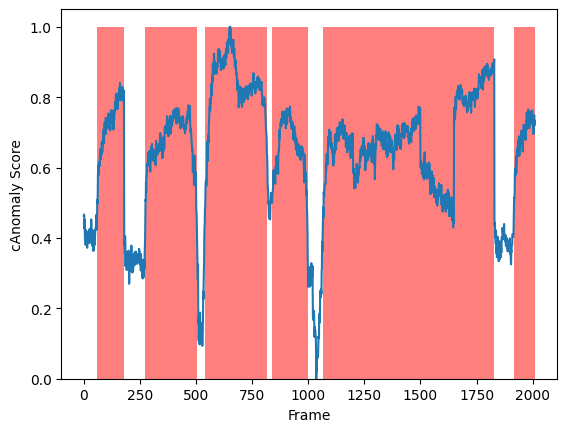

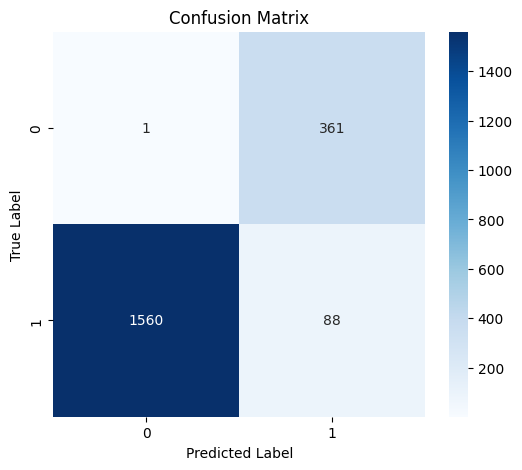

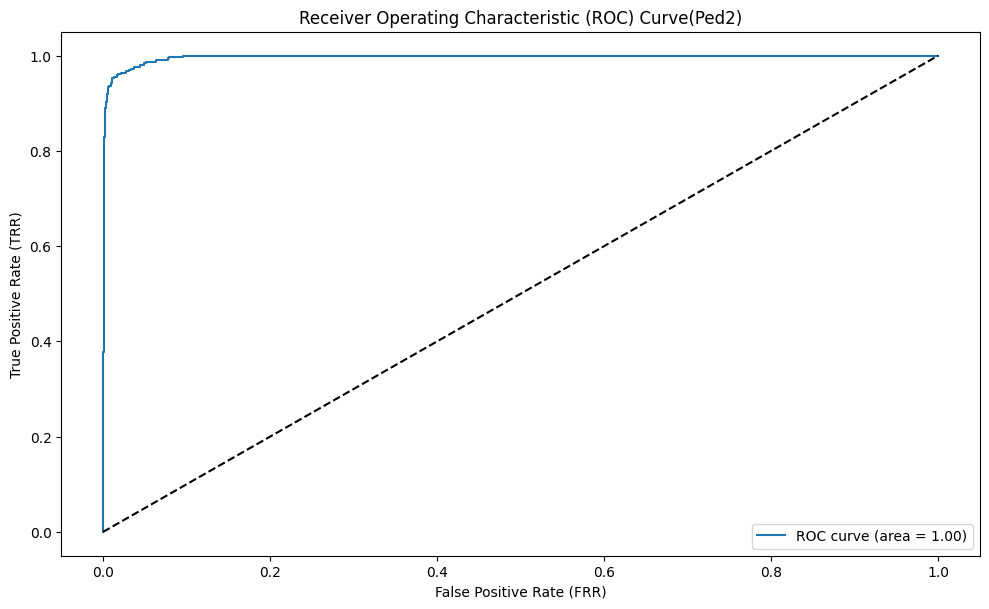

In [2]:
# To run evaluation from the notebook, you can invoke the main() function from eval.py
import sys
sys.argv = [
    'eval.py', 
    '--batch_size', '5', 
    '--trained_model', 'latest_ped2', 
    '--dataset', 'ped2', 
    '--show_curve', 'True', 
    '--show_heatmap', 'True', 
    '--manualseed', '-1', 
    '--generator_iters', '20000', 
    '--cuda', 'True'
]
import eval
eval.main()


# Upload to Google Drive

In [ ]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [ ]:
download_file('/kaggle/working/weights/latest_ped2.pth', 'out')